# **肥満リスクの多クラス予測**
(Multi-Class Prediction of Obesity Risk)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


# 参考資料
**書籍**


**Kaggle**

**記事**

**自分で作成したファイル**
最近作成したファイルを10個程度掲載しています
- [EDA_Bank_for Japanese](https://www.kaggle.com/code/cheesegue/eda-bank-for-japanese)
- [👣EDA_Titanic_日本語向け](https://www.kaggle.com/code/cheesegue/eda-titanic)
- [EDA_LLM-Detect_日本語向け](https://www.kaggle.com/code/cheesegue/eda-llm-detect)
- [👣LGBM_Cirrhosis_日本語向け](https://www.kaggle.com/code/cheesegue/lgbm-cirrhosis)
- [👣EDA_Horses_日本語向け](https://www.kaggle.com/code/cheesegue/eda-horses)
- [👣EDA_Software_日本語向け](https://www.kaggle.com/code/cheesegue/eda-software)
- [👣EDA_Smorker_日本語向け](https://www.kaggle.com/code/cheesegue/eda-smorker)
- [EDA_Cirrhosis-Outcomes_日本語向け](https://www.kaggle.com/code/cheesegue/eda-cirrhosis-outcomes)
- [EDA_Mohs-Hardness_日本語向け](https://www.kaggle.com/code/cheesegue/eda-mohs-hardness)


## 概要
1. 目的： 
2. 目次:
    * ライブラリ・データセットのインポート
    * EDA
3. **目標**: 
    
4. 目的変数： 'NObeyesdad'

5. コンペの問題提起
    



#### 評価指標：　Accuracy

# ライブラリ・データセットのインポート

In [2]:
!pip install sweetviz
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 91.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from IPython.display import display
import sweetviz as sv

import warnings; warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
plt.style.use('ggplot')

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import missingno as msno

from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier # 特徴量の重要度評価で用いる

# 敵対性の検証で用いる
from category_encoders import OneHotEncoder
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

## 実行時間を調べるために使う

In [5]:
import datetime
import time
import math

start_time = time.time()

def changeHMS(s):
    h = math.floor(s / 3600)
    if h > 0:
        s = s - h * 3600
        indi_h = str(h) + 'h'
    else:
        indi_h = ''
    m = math.floor(s / 60)
    if m > 0:
        indi_m = str(m) + 'm'
    else:
        indi_m = ''
    s = math.floor(s % 60)
    time = indi_h + indi_m + str(s) + 's'
    return time

In [6]:
FILE_PATH = '/kaggle/input/playground-series-s4e2/'
OUTPUT_DIR = '/kaggle/working/'
train = pd.read_csv(FILE_PATH + 'train.csv')
test = pd.read_csv(FILE_PATH + 'test.csv')

## id と目的変数の分割

In [7]:
train_id = train['id']
train.drop('id', axis=1, inplace=True)

test_id = test['id']
test.drop('id', axis=1, inplace=True)

target = train['NObeyesdad']
target_col = 'NObeyesdad'
target_name = str(train.iloc[:, [-1]].columns.tolist())
print(target_name)

['NObeyesdad']


## データ(DataFrame)の構成を調べる

In [8]:
train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.44301,1.70000,81.66995,yes,yes,2.00000,2.98330,Sometimes,no,2.76357,no,0.00000,0.97647,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.00000,1.56000,57.00000,yes,yes,2.00000,3.00000,Frequently,no,2.00000,no,1.00000,1.00000,no,Automobile,Normal_Weight
2,Female,18.00000,1.71146,50.16575,yes,yes,1.88053,1.41169,Sometimes,no,1.91038,no,0.86604,1.67358,no,Public_Transportation,Insufficient_Weight
3,Female,20.95274,1.71073,131.27485,yes,yes,3.00000,3.00000,Sometimes,no,1.67406,no,1.46786,0.78020,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.64108,1.91419,93.79806,yes,yes,2.67966,1.97147,Sometimes,no,1.97985,no,1.96797,0.93172,Sometimes,Public_Transportation,Overweight_Level_II


In [9]:
test.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Male,26.89989,1.84829,120.64418,yes,yes,2.93862,3.00000,Sometimes,no,2.82563,no,0.85540,0.00000,Sometimes,Public_Transportation
1,Female,21.00000,1.60000,66.00000,yes,yes,2.00000,1.00000,Sometimes,no,3.00000,no,1.00000,0.00000,Sometimes,Public_Transportation
2,Female,26.00000,1.64335,111.60055,yes,yes,3.00000,3.00000,Sometimes,no,2.62188,no,0.00000,0.25050,Sometimes,Public_Transportation
3,Male,20.97925,1.55313,103.66912,yes,yes,2.00000,2.97791,Sometimes,no,2.78642,no,0.09485,0.00000,Sometimes,Public_Transportation
4,Female,26.00000,1.62740,104.83535,yes,yes,3.00000,3.00000,Sometimes,no,2.65353,no,0.00000,0.74107,Sometimes,Public_Transportation


In [10]:
print('train: ')
print(train.shape)
print(train.info())
print('\n')
print('test: ')
print(test.shape)
print(test.info())

train: 
(20758, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  object 
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  object 
 5   FAVC                            20758 non-null  object 
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  object 
 9   SMOKE                           20758 non-null  object 
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  object 
 12  FAF         

In [11]:
train_columns = train.columns
train_index = train.index
train_data = train.values # values

test_columns = test.columns
test_index = test.index
test_data = test.values # values

print('train: ')
print(type(train_columns))
print(type(train_index))
print(type(train_data))
print('\n')
print('test: ')
print(type(test_columns))
print(type(test_index))
print(type(test_data))

train: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


test: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


In [12]:
with pd.option_context('display.max_rows', 8):
    display(train)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.44301,1.70000,81.66995,yes,yes,2.00000,2.98330,Sometimes,no,2.76357,no,0.00000,0.97647,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.00000,1.56000,57.00000,yes,yes,2.00000,3.00000,Frequently,no,2.00000,no,1.00000,1.00000,no,Automobile,Normal_Weight
2,Female,18.00000,1.71146,50.16575,yes,yes,1.88053,1.41169,Sometimes,no,1.91038,no,0.86604,1.67358,no,Public_Transportation,Insufficient_Weight
3,Female,20.95274,1.71073,131.27485,yes,yes,3.00000,3.00000,Sometimes,no,1.67406,no,1.46786,0.78020,Sometimes,Public_Transportation,Obesity_Type_III
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20754,Male,18.00000,1.71000,50.00000,no,yes,3.00000,4.00000,Frequently,no,1.00000,no,2.00000,1.00000,Sometimes,Public_Transportation,Insufficient_Weight
20755,Male,20.10103,1.81956,105.58049,yes,yes,2.40782,3.00000,Sometimes,no,2.00000,no,1.15804,1.19844,no,Public_Transportation,Obesity_Type_II
20756,Male,33.85295,1.70000,83.52011,yes,yes,2.67124,1.97147,Sometimes,no,2.14484,no,0.00000,0.97383,no,Automobile,Overweight_Level_II
20757,Male,26.68038,1.81655,118.13490,yes,yes,3.00000,3.00000,Sometimes,no,2.00356,no,0.68449,0.71382,Sometimes,Public_Transportation,Obesity_Type_II


In [13]:
with pd.option_context('display.max_rows', 8):
    display(test)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Male,26.89989,1.84829,120.64418,yes,yes,2.93862,3.00000,Sometimes,no,2.82563,no,0.85540,0.00000,Sometimes,Public_Transportation
1,Female,21.00000,1.60000,66.00000,yes,yes,2.00000,1.00000,Sometimes,no,3.00000,no,1.00000,0.00000,Sometimes,Public_Transportation
2,Female,26.00000,1.64335,111.60055,yes,yes,3.00000,3.00000,Sometimes,no,2.62188,no,0.00000,0.25050,Sometimes,Public_Transportation
3,Male,20.97925,1.55313,103.66912,yes,yes,2.00000,2.97791,Sometimes,no,2.78642,no,0.09485,0.00000,Sometimes,Public_Transportation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13836,Female,29.00000,1.59000,62.00000,no,yes,3.00000,3.00000,Sometimes,no,2.00000,no,0.00000,0.00000,Sometimes,Public_Transportation
13837,Female,22.93561,1.58555,44.37664,no,yes,3.00000,2.27374,Frequently,no,2.00000,no,1.94984,1.00000,Sometimes,Public_Transportation
13838,Male,21.00000,1.62000,53.00000,yes,yes,2.00000,3.00000,Sometimes,no,2.00000,no,3.00000,2.00000,no,Public_Transportation
13839,Male,26.49093,1.81226,120.98051,yes,yes,2.74499,3.00000,Sometimes,no,2.20598,no,1.30429,0.63087,Sometimes,Public_Transportation


## データ型を理解する

In [14]:
print('train: ')
print(train.dtypes)
print(train.dtypes.value_counts())
print('\n')
print('test: ')
print(test.dtypes)
print(test.dtypes.value_counts())

train: 
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object
object     9
float64    8
Name: count, dtype: int64


test: 
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     

In [15]:
# 説明変数をデータ型ごとに代入する
numerical_features = test._get_numeric_data().columns
categorical_features = test.drop(numerical_features, axis=1).columns
numerical_features, categorical_features

(Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object'),
 Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
        'SCC', 'CALC', 'MTRANS'],
       dtype='object'))

# EDA(探索的データ分析)

What's your EDA?  
**EDA(探索的データ分析)**: データセットに適宜前処理を施しつつ様々な統計量を抽出して可視化し、そこに内在する特性・パターン・偏りについて探索的に仮説立案・検証を繰り返して分析すること

## 要約統計量

In [16]:
train.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
Age,20758.000000,23.841804,5.688072,14.000000,20.000000,22.815416,26.000000,61.000000
Height,20758.000000,1.700245,0.087312,1.450000,1.631856,1.700000,1.762887,1.975663
Weight,20758.000000,87.887768,26.379443,39.000000,66.000000,84.064875,111.600553,165.057269
FCVC,20758.000000,2.445908,0.533218,1.000000,2.000000,2.393837,3.000000,3.000000
NCP,20758.000000,2.761332,0.705375,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,20758.000000,2.029418,0.608467,1.000000,1.792022,2.000000,2.549617,3.000000
FAF,20758.000000,0.981747,0.838302,0.000000,0.008013,1.000000,1.587406,3.000000
TUE,20758.000000,0.616756,0.602113,0.000000,0.000000,0.573887,1.000000,2.000000


In [17]:
test.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
Age,13840.000000,23.952740,5.799814,14.000000,20.000000,22.906342,26.000000,61.000000
Height,13840.000000,1.698934,0.088761,1.450000,1.631662,1.700000,1.760710,1.980000
Weight,13840.000000,87.384504,26.111819,39.000000,65.000000,83.952968,111.157811,165.057269
FCVC,13840.000000,2.442898,0.531606,1.000000,2.000000,2.358087,3.000000,3.000000
NCP,13840.000000,2.750610,0.710927,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,13840.000000,2.032044,0.611230,1.000000,1.771781,2.000000,2.552388,3.000000
FAF,13840.000000,0.974532,0.840361,0.000000,0.001086,1.000000,1.571865,3.000000
TUE,13840.000000,0.611033,0.608005,0.000000,0.000000,0.552498,1.000000,2.000000


In [18]:
desc_train = pd.DataFrame(index=list(train))
desc_train['count'] = train.count()
desc_train['nunique'] = train.nunique()
desc_train['%unique'] = desc_train['nunique'] / len(train) * 100
desc_train['null'] = train.isnull().sum()
desc_train['type'] = train.dtypes
desc_train = desc_train.style.background_gradient(cmap='Greens')
# desc_train = pd.concat([desc_train, train.describe().T], axis=1)
desc_train

,count,nunique,%unique,null,type
Gender,20758,2,0.009635,0,object
Age,20758,1703,8.204066,0,float64
Height,20758,1833,8.830330,0,float64
Weight,20758,1979,9.533674,0,float64
family_history_with_overweight,20758,2,0.009635,0,object
FAVC,20758,2,0.009635,0,object
FCVC,20758,934,4.499470,0,float64
NCP,20758,689,3.319202,0,float64
CAEC,20758,4,0.019270,0,object
SMOKE,20758,2,0.009635,0,object


In [19]:
desc_test = pd.DataFrame(index=list(test))
desc_test['count'] = test.count()
desc_test['nunique'] = test.nunique()
desc_test['%unique'] = desc_test['nunique'] / len(test) * 100
desc_test['null'] = test.isnull().sum()
desc_test['type'] = test.dtypes
desc_test = desc_test.style.background_gradient(cmap='Blues')
# desc_test = pd.concat([desc_test, test.describe().T], axis=1)
desc_test

,count,nunique,%unique,null,type
Gender,13840,2,0.014451,0,object
Age,13840,1539,11.119942,0,float64
Height,13840,1739,12.565029,0,float64
Weight,13840,1798,12.991329,0,float64
family_history_with_overweight,13840,2,0.014451,0,object
FAVC,13840,2,0.014451,0,object
FCVC,13840,828,5.982659,0,float64
NCP,13840,649,4.689306,0,float64
CAEC,13840,4,0.028902,0,object
SMOKE,13840,2,0.014451,0,object


In [20]:
# 特定の次元方向についての分散
print('train: ')
print(np.var(train[numerical_features], axis=0))
print('\n')
print('test: ')
print(np.var(test[numerical_features], axis=0))

train: 
Age       32.35260
Height     0.00762
Weight   695.84149
FCVC       0.28431
NCP        0.49753
CH2O       0.37021
FAF        0.70272
TUE        0.36252
dtype: float64


test: 
Age       33.63541
Height     0.00788
Weight   681.77780
FCVC       0.28258
NCP        0.50538
CH2O       0.37357
FAF        0.70616
TUE        0.36964
dtype: float64


### 変動係数

変動係数は、標準偏差を平均値で割った値
* スケールに依存せず、比較できるようになる

In [21]:
train[numerical_features].std() / train[numerical_features].mean()

Age      0.23858
Height   0.05135
Weight   0.30015
FCVC     0.21800
NCP      0.25545
CH2O     0.29982
FAF      0.85389
TUE      0.97626
dtype: float64

## 尖度（せんど）と歪度（わいど）

- 分布が正規分布からどれだけ歪んでいるかを表す統計量で、左右対称性を示す指標のこと
- 分布が正規分布からどれだけ尖っているかを表す統計量で、山の尖り度と裾の広がり度

In [22]:
print('train: ')
print(train[numerical_features].kurtosis())
print('\n')
print('test: ')
print(test[numerical_features].kurtosis())

train: 
Age       3.70060
Height   -0.55963
Weight   -0.99704
FCVC     -0.89300
NCP       1.83727
CH2O     -0.74418
FAF      -0.49484
TUE      -0.41773
dtype: float64


test: 
Age       3.54038
Height   -0.53783
Weight   -1.01276
FCVC     -0.89469
NCP       1.70076
CH2O     -0.75717
FAF      -0.46563
TUE      -0.40771
dtype: float64


### 目的変数の尖度と歪度

In [23]:
# # skewness and kurtosis
# print("尖度: %f" % target.skew())
# print("歪度: %f" % target.kurt())

## 欠損値

In [24]:
print('train: ')
print(train.isna().sum().any())
print(train.isnull().sum())
print('\n')
print('test: ')
print(test.isna().sum().any())
print(test.isnull().sum())

train: 
False
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


test: 
False
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                 

Axes(0.125,0.11;0.698618x0.77)
Axes(0.125,0.11;0.698618x0.77)


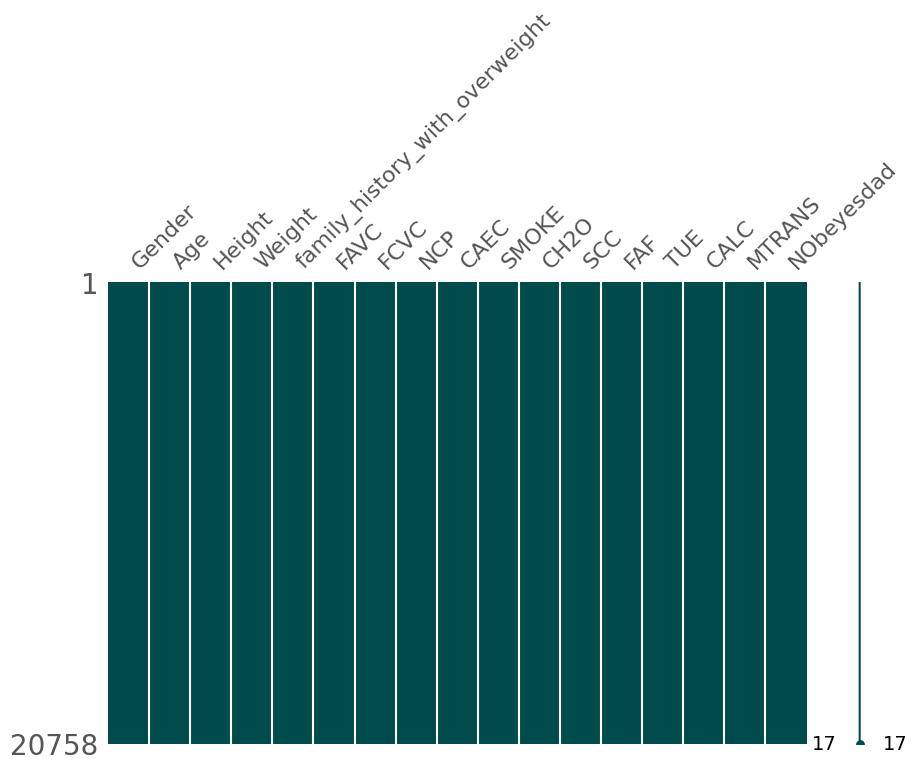

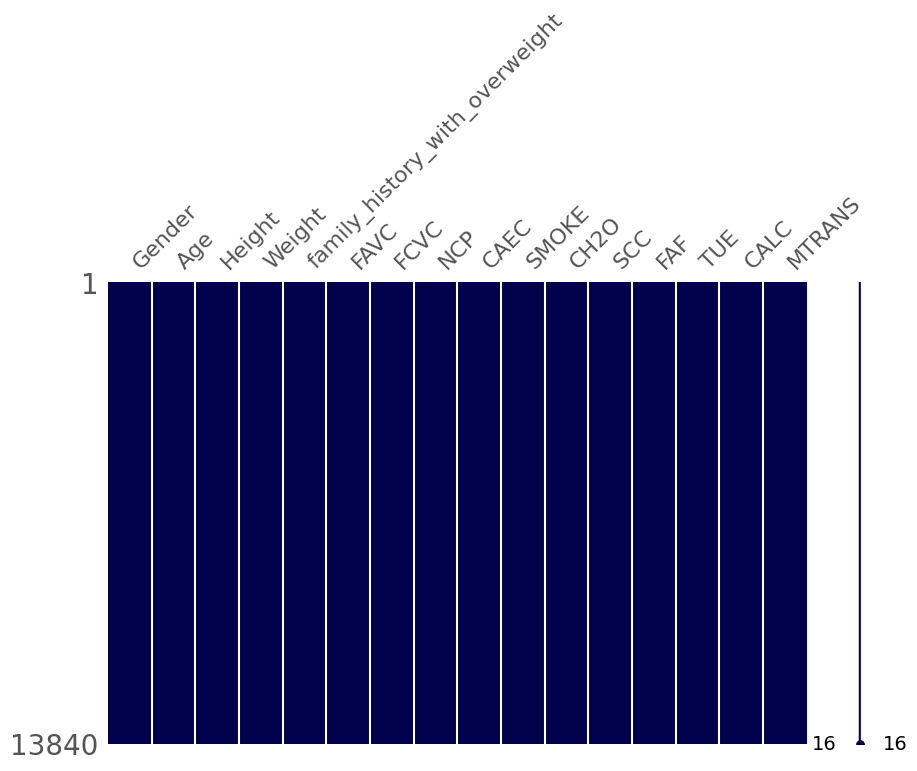

In [25]:
# 欠損値の有無を可視化する
print(msno.matrix(df=train, figsize=(10, 6), color=(0, .3, .3)))
print(msno.matrix(df=test, figsize=(10, 6), color=(0, 0, .3)))

元々欠損値がないデータ

## 重複データ

In [26]:
total = pd.concat([train.drop(target_col, axis=1), test], axis=0) # 目的変数を指定する
total.duplicated().sum()

0

## カラムごとのユニークな値を調べる

In [27]:
train[train.columns].nunique().sort_values(ascending=True)

Gender                               2
SCC                                  2
SMOKE                                2
family_history_with_overweight       2
FAVC                                 2
CALC                                 3
CAEC                                 4
MTRANS                               5
NObeyesdad                           7
NCP                                689
FCVC                               934
TUE                               1297
FAF                               1360
CH2O                              1506
Age                               1703
Height                            1833
Weight                            1979
dtype: int64

### 目的変数

In [28]:
print(target_name +' Class labels:', np.unique(target))

['NObeyesdad'] Class labels: ['Insufficient_Weight' 'Normal_Weight' 'Obesity_Type_I' 'Obesity_Type_II'
 'Obesity_Type_III' 'Overweight_Level_I' 'Overweight_Level_II']


## データセットのプロット（分布）

### 密度関数（ヒストグラム）

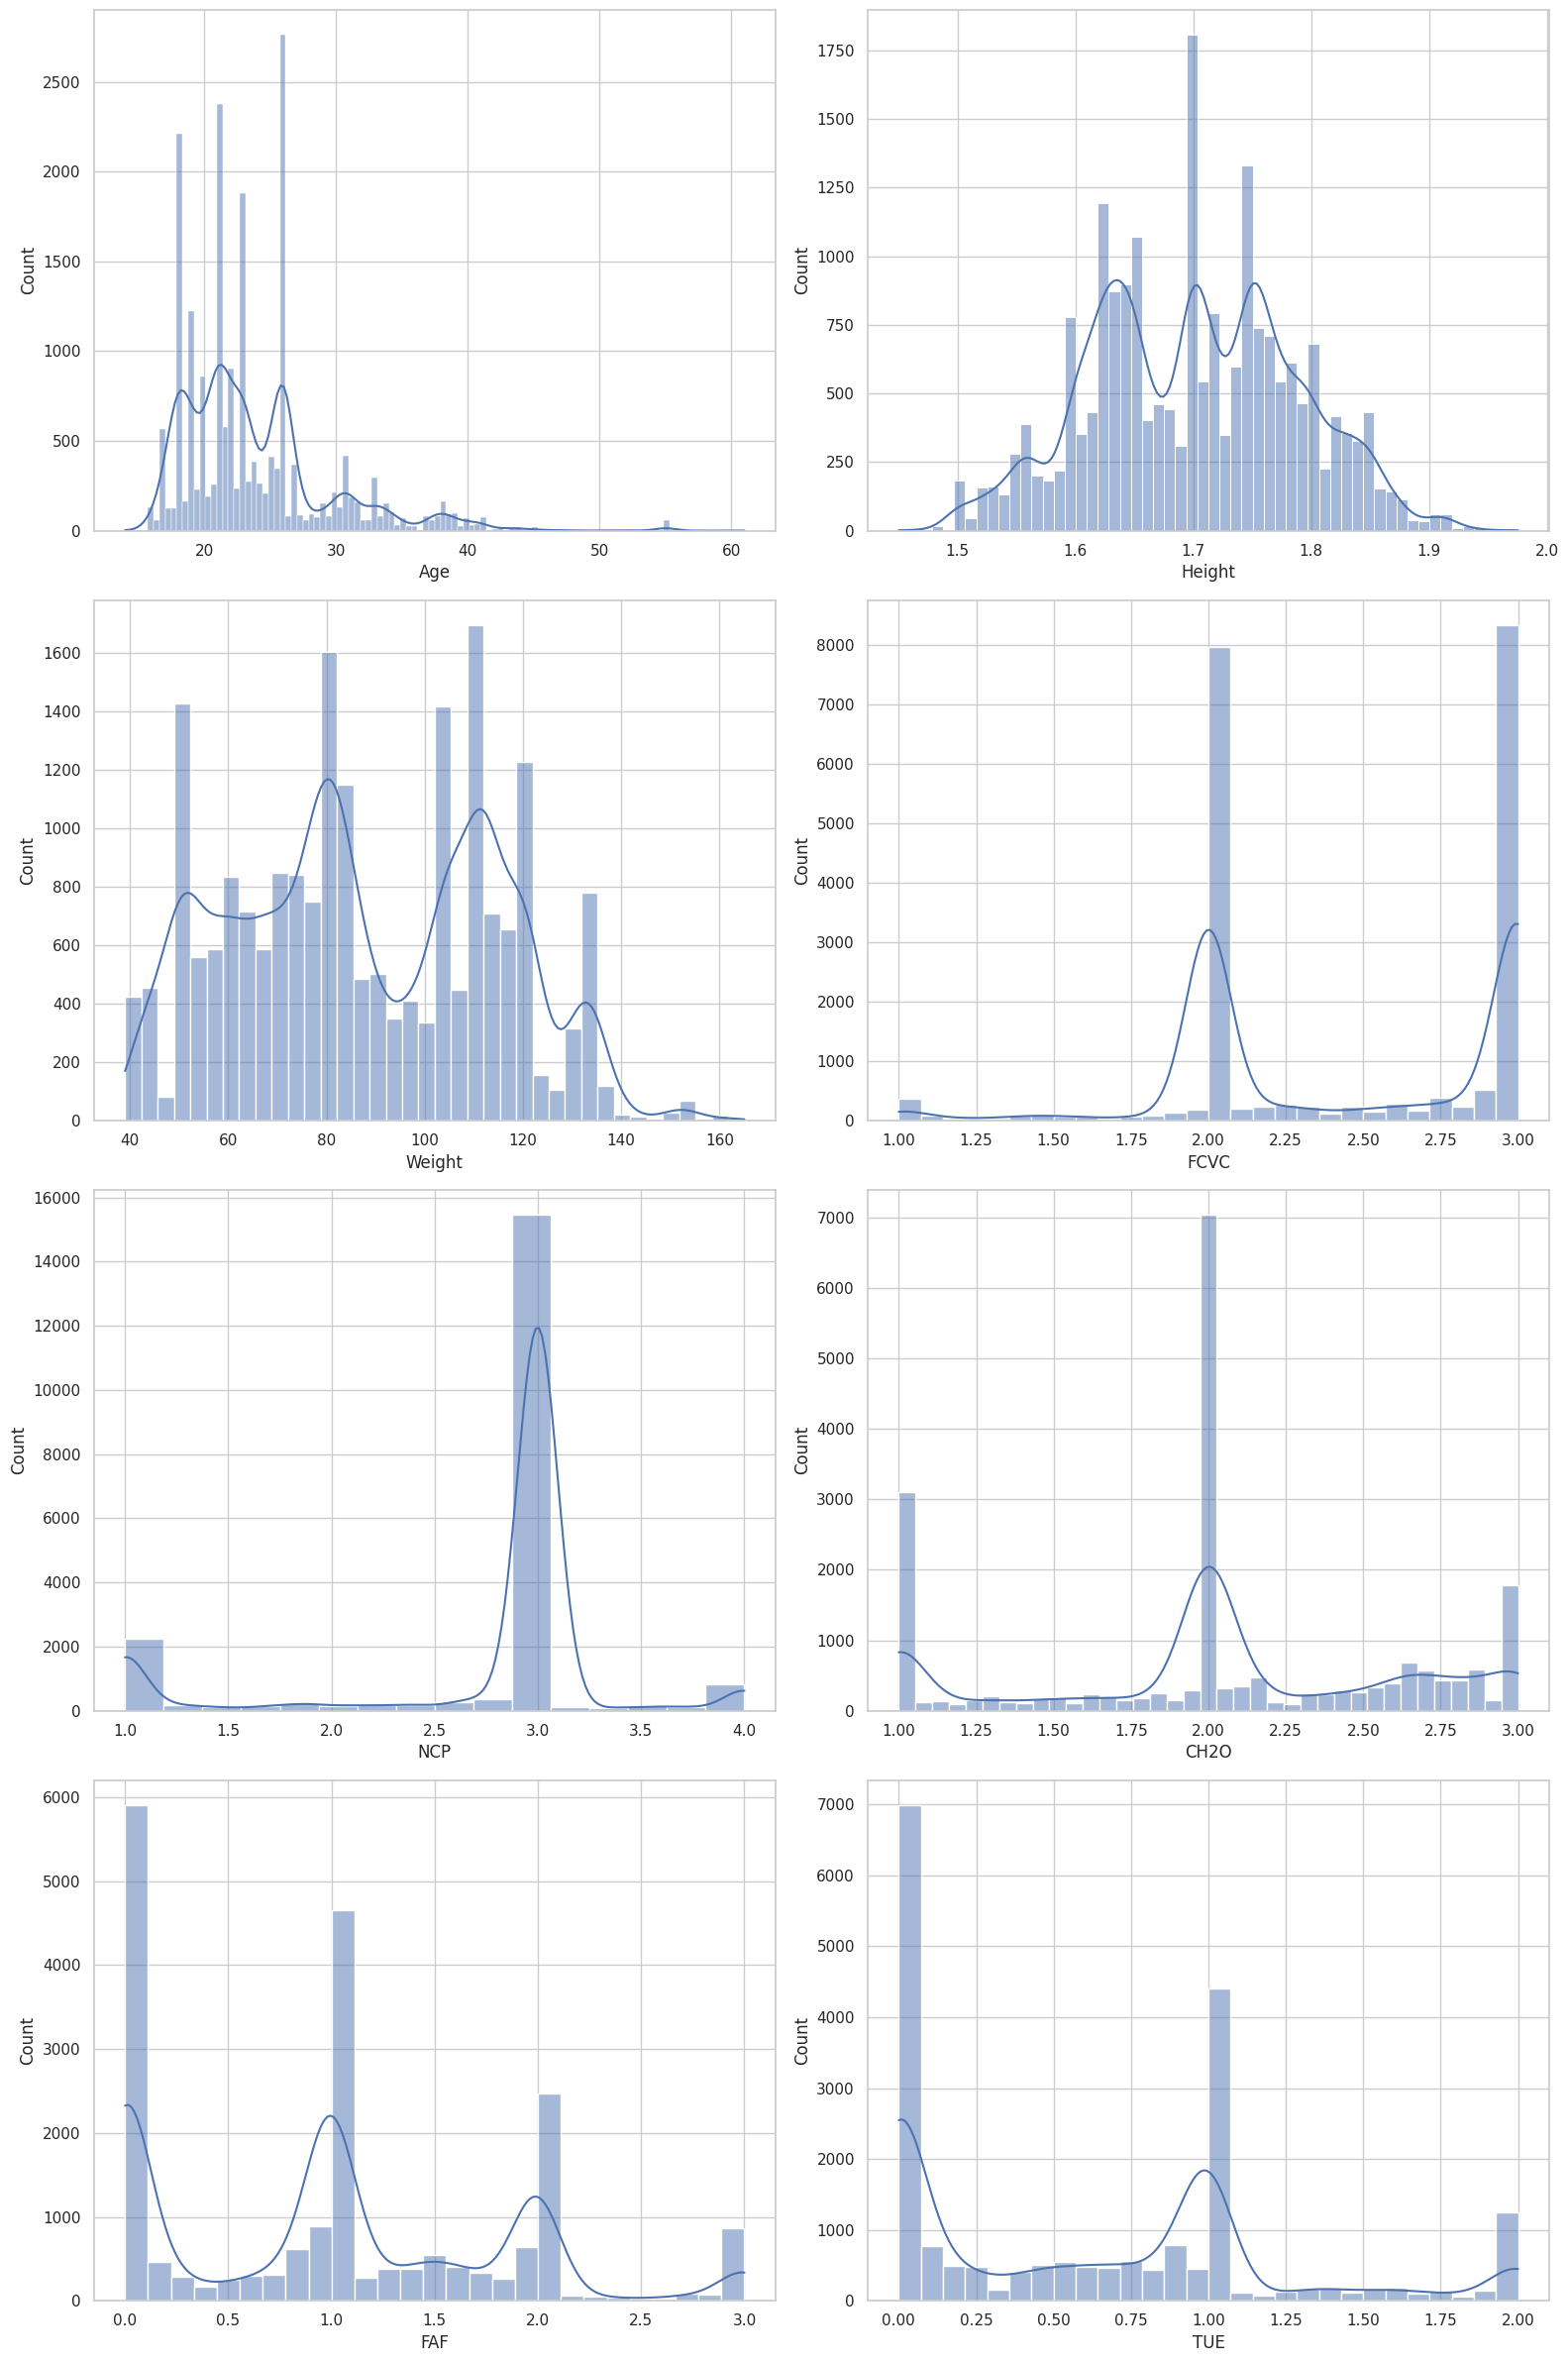

In [29]:
sns.set(style="whitegrid")

rows = (len(numerical_features) + 1) // 2
cols = 2
_, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8 * cols, 6 * rows))

for i, feature_name in enumerate(numerical_features):
    row_idx, col_idx = divmod(i, cols)
    sns.histplot(data=train, x=feature_name, kde=True, ax=axes[row_idx, col_idx])

plt.tight_layout()

plt.show()

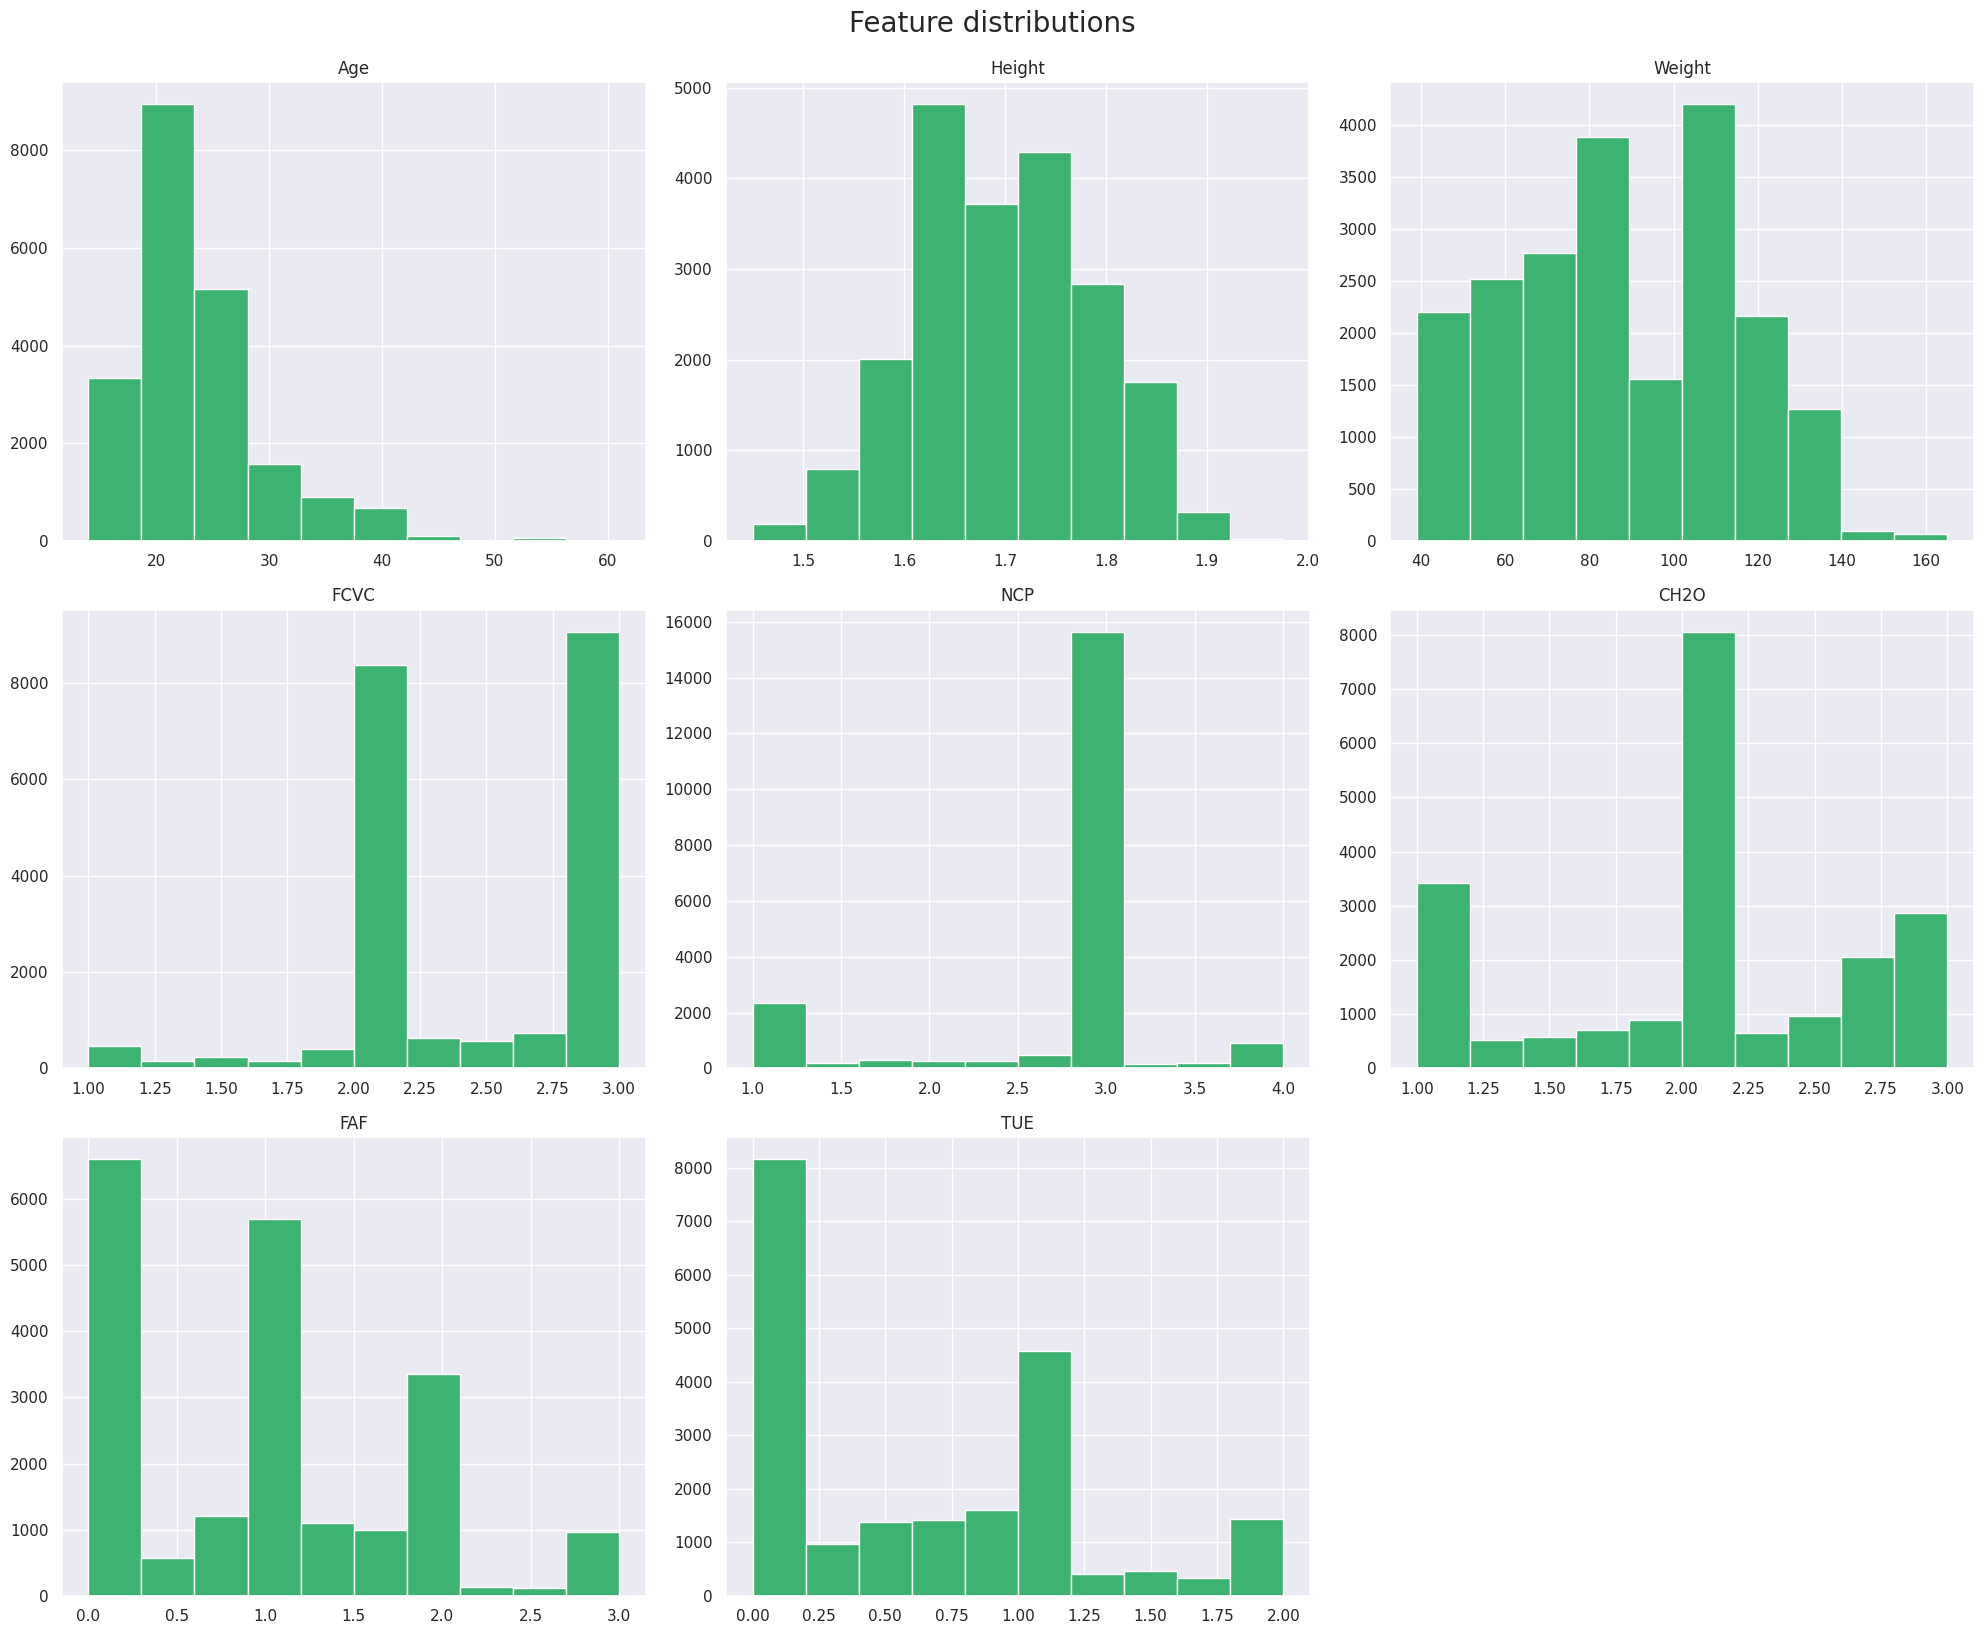

In [30]:
sns.set(rc={'figure.figsize': (20, 16)})
train.hist(color='mediumseagreen')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

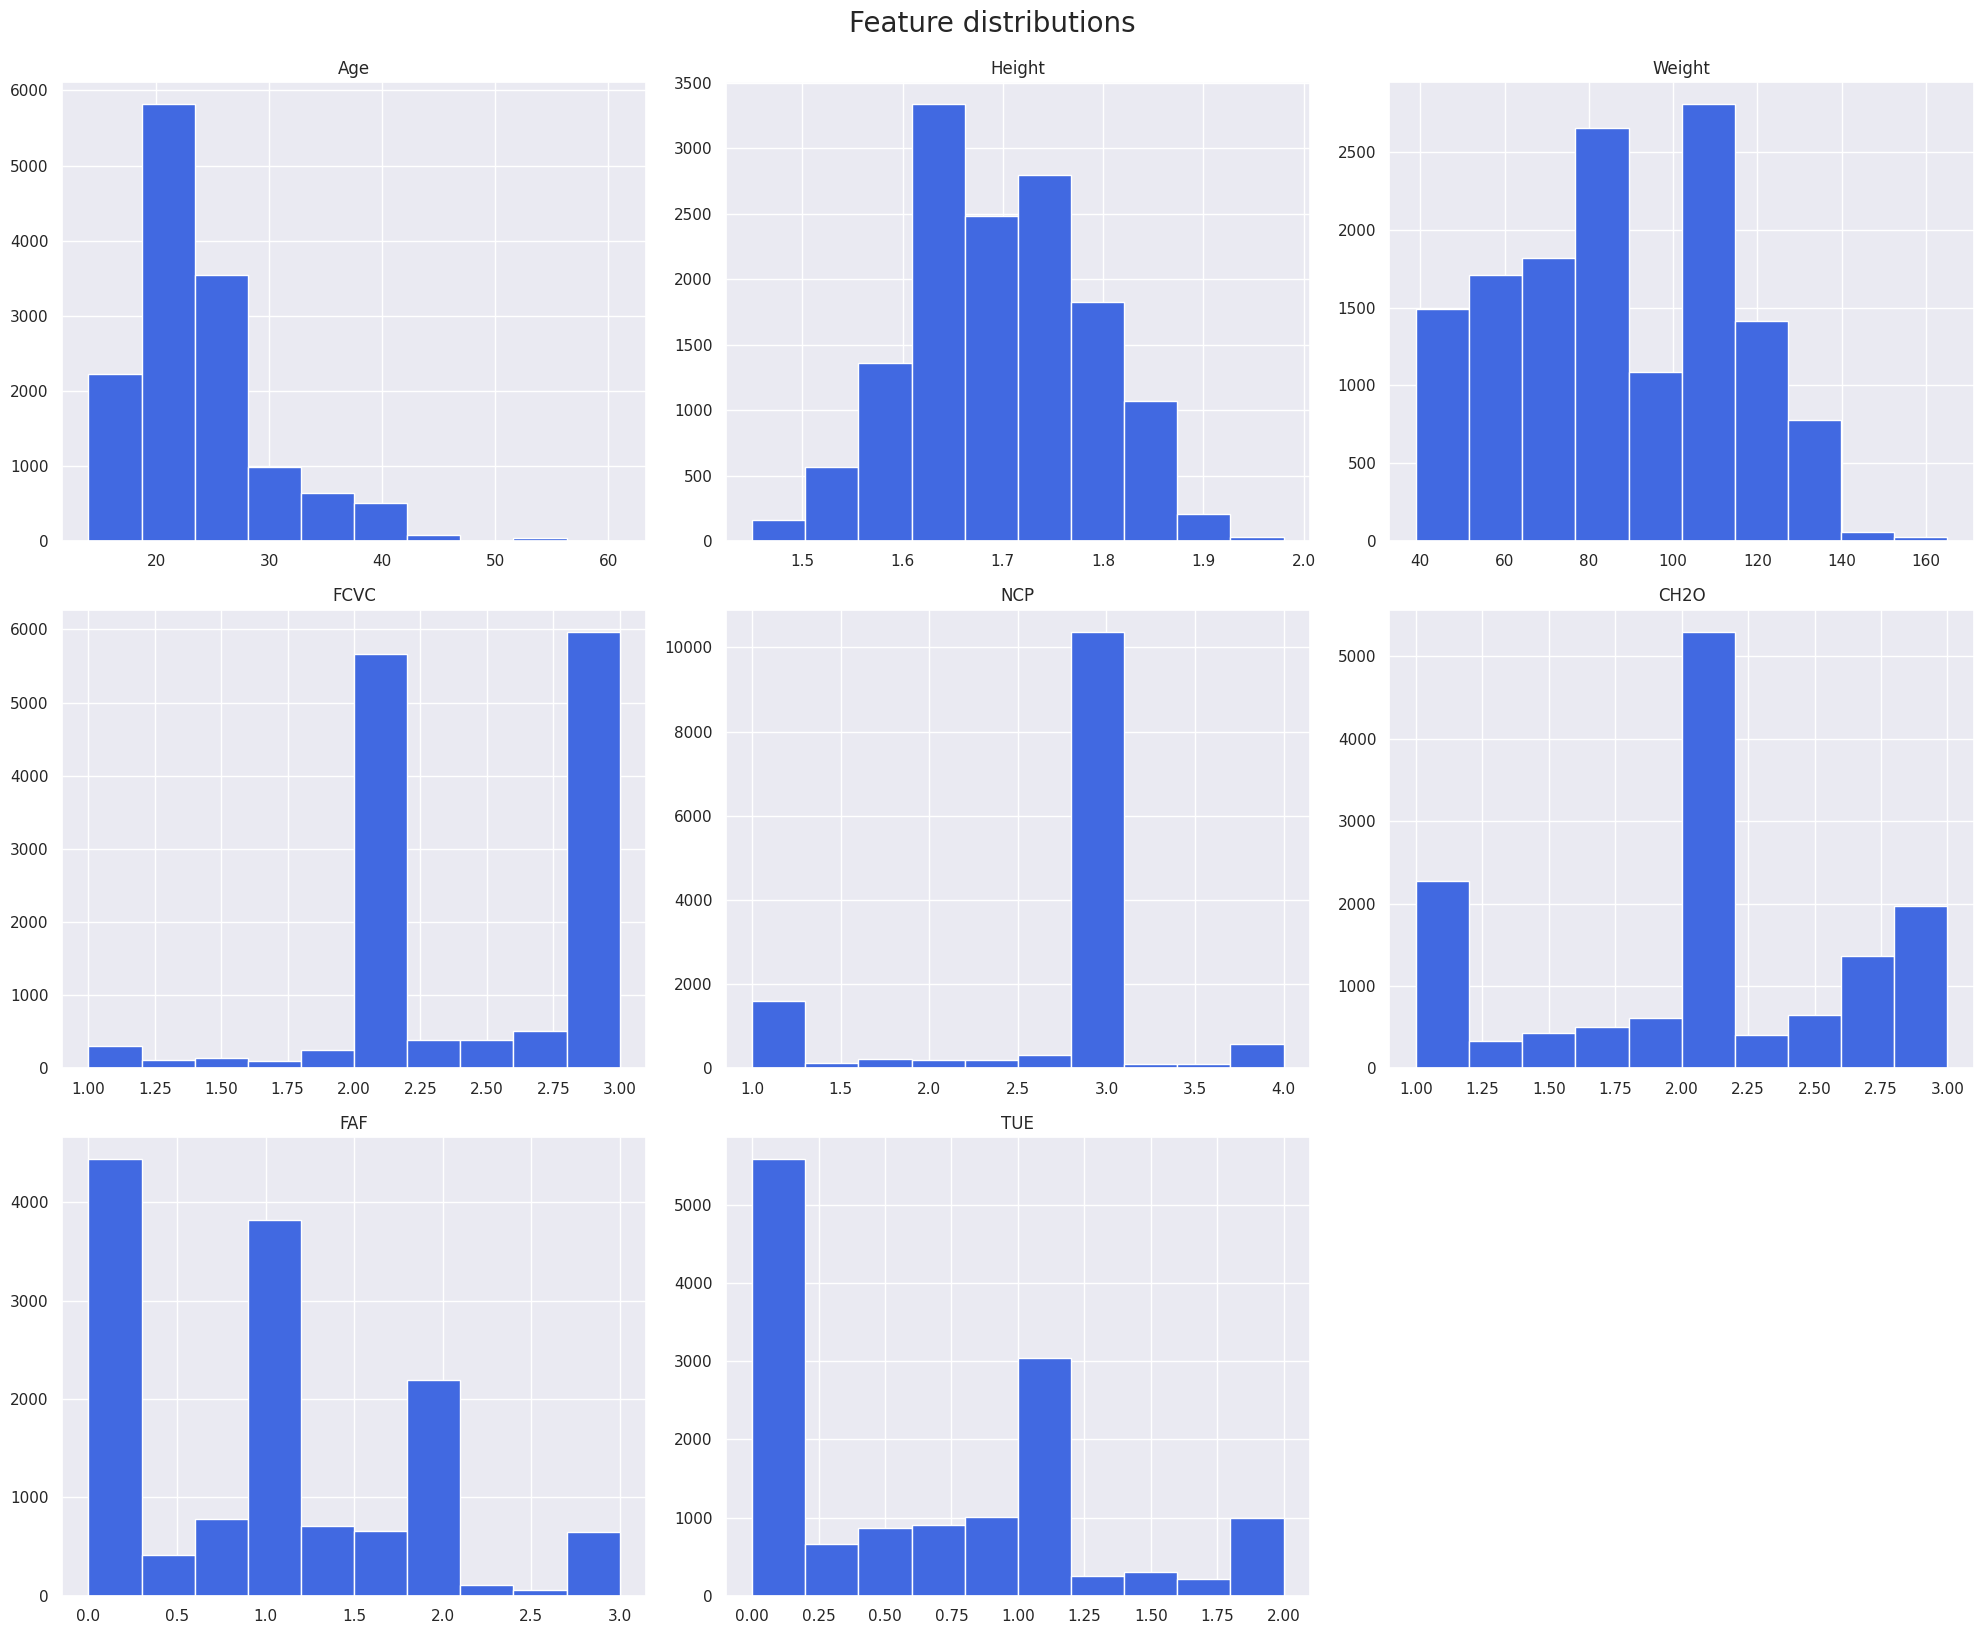

In [31]:
sns.set(rc={'figure.figsize': (20, 16)})
test.hist(color='royalblue')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

#### データの分布を可視化する

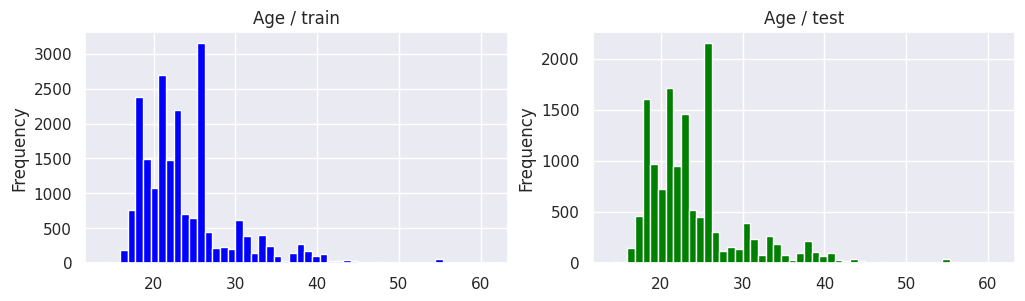

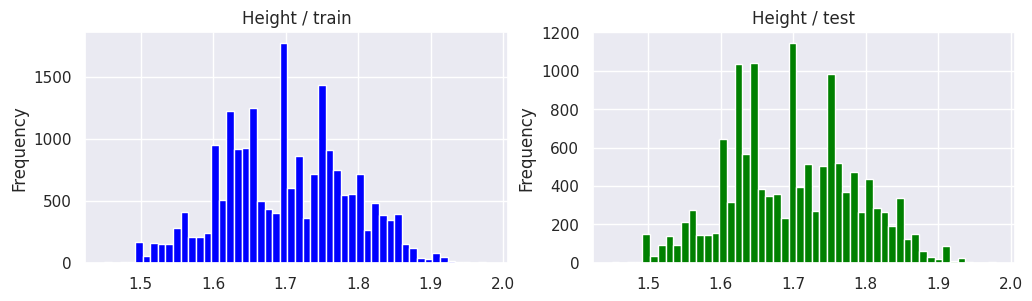

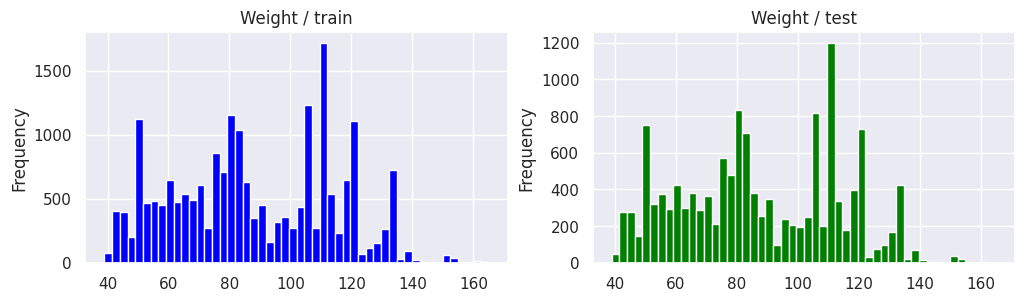

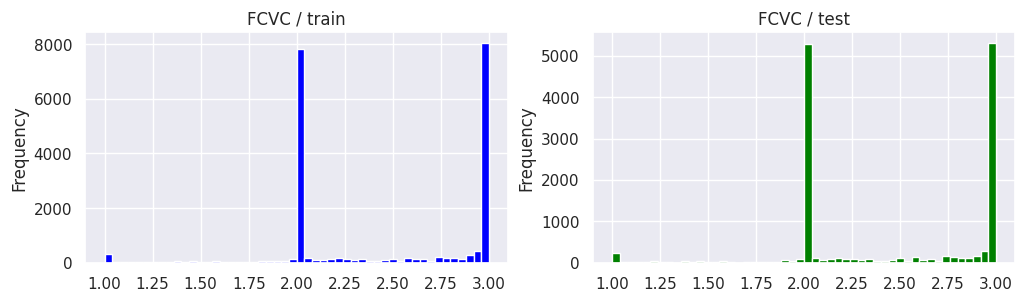

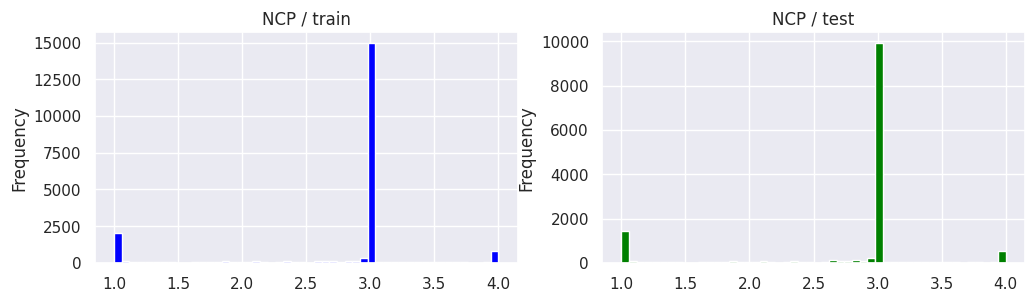

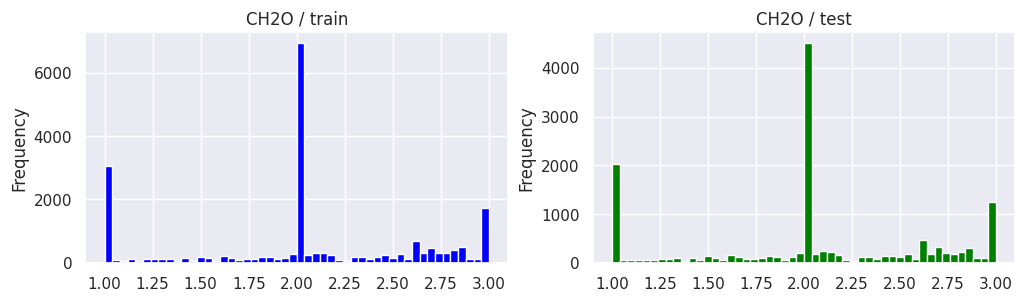

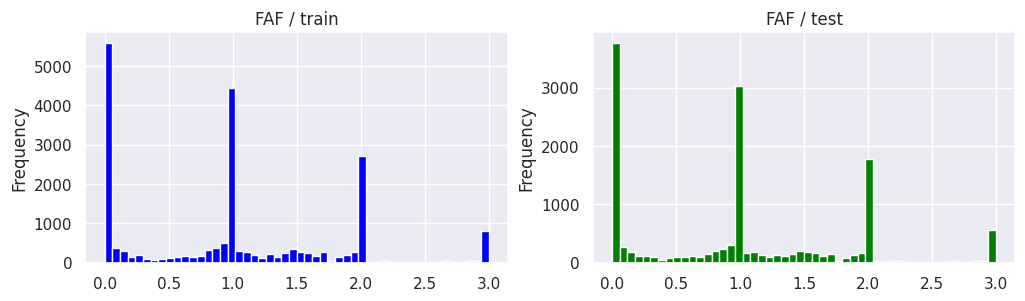

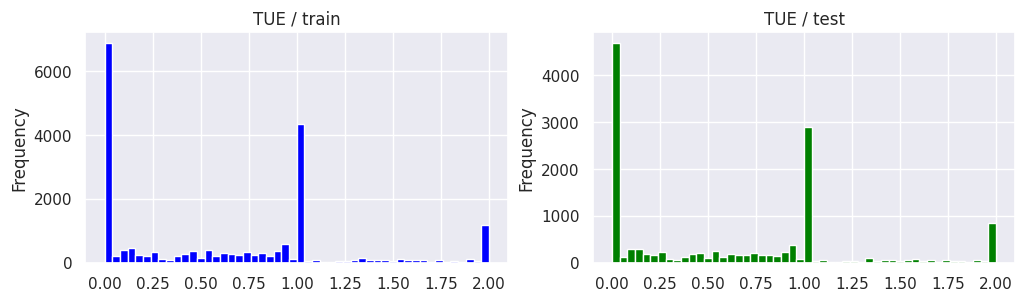

In [32]:
feature = train[numerical_features]

for feat in feature:
    plt.figure(figsize=(12, 3))
    ax1 = plt.subplot(1, 2, 1)
    train[feat].plot(kind='hist', bins=50, color='blue')
    plt.title(feat + ' / train')
    ax2 = plt.subplot(1, 2, 2, sharex=ax1)
    test[feat].plot(kind='hist', bins=50, color='green')
    plt.title(feat + ' / test')

    plt.show()

#### データを対数変換する

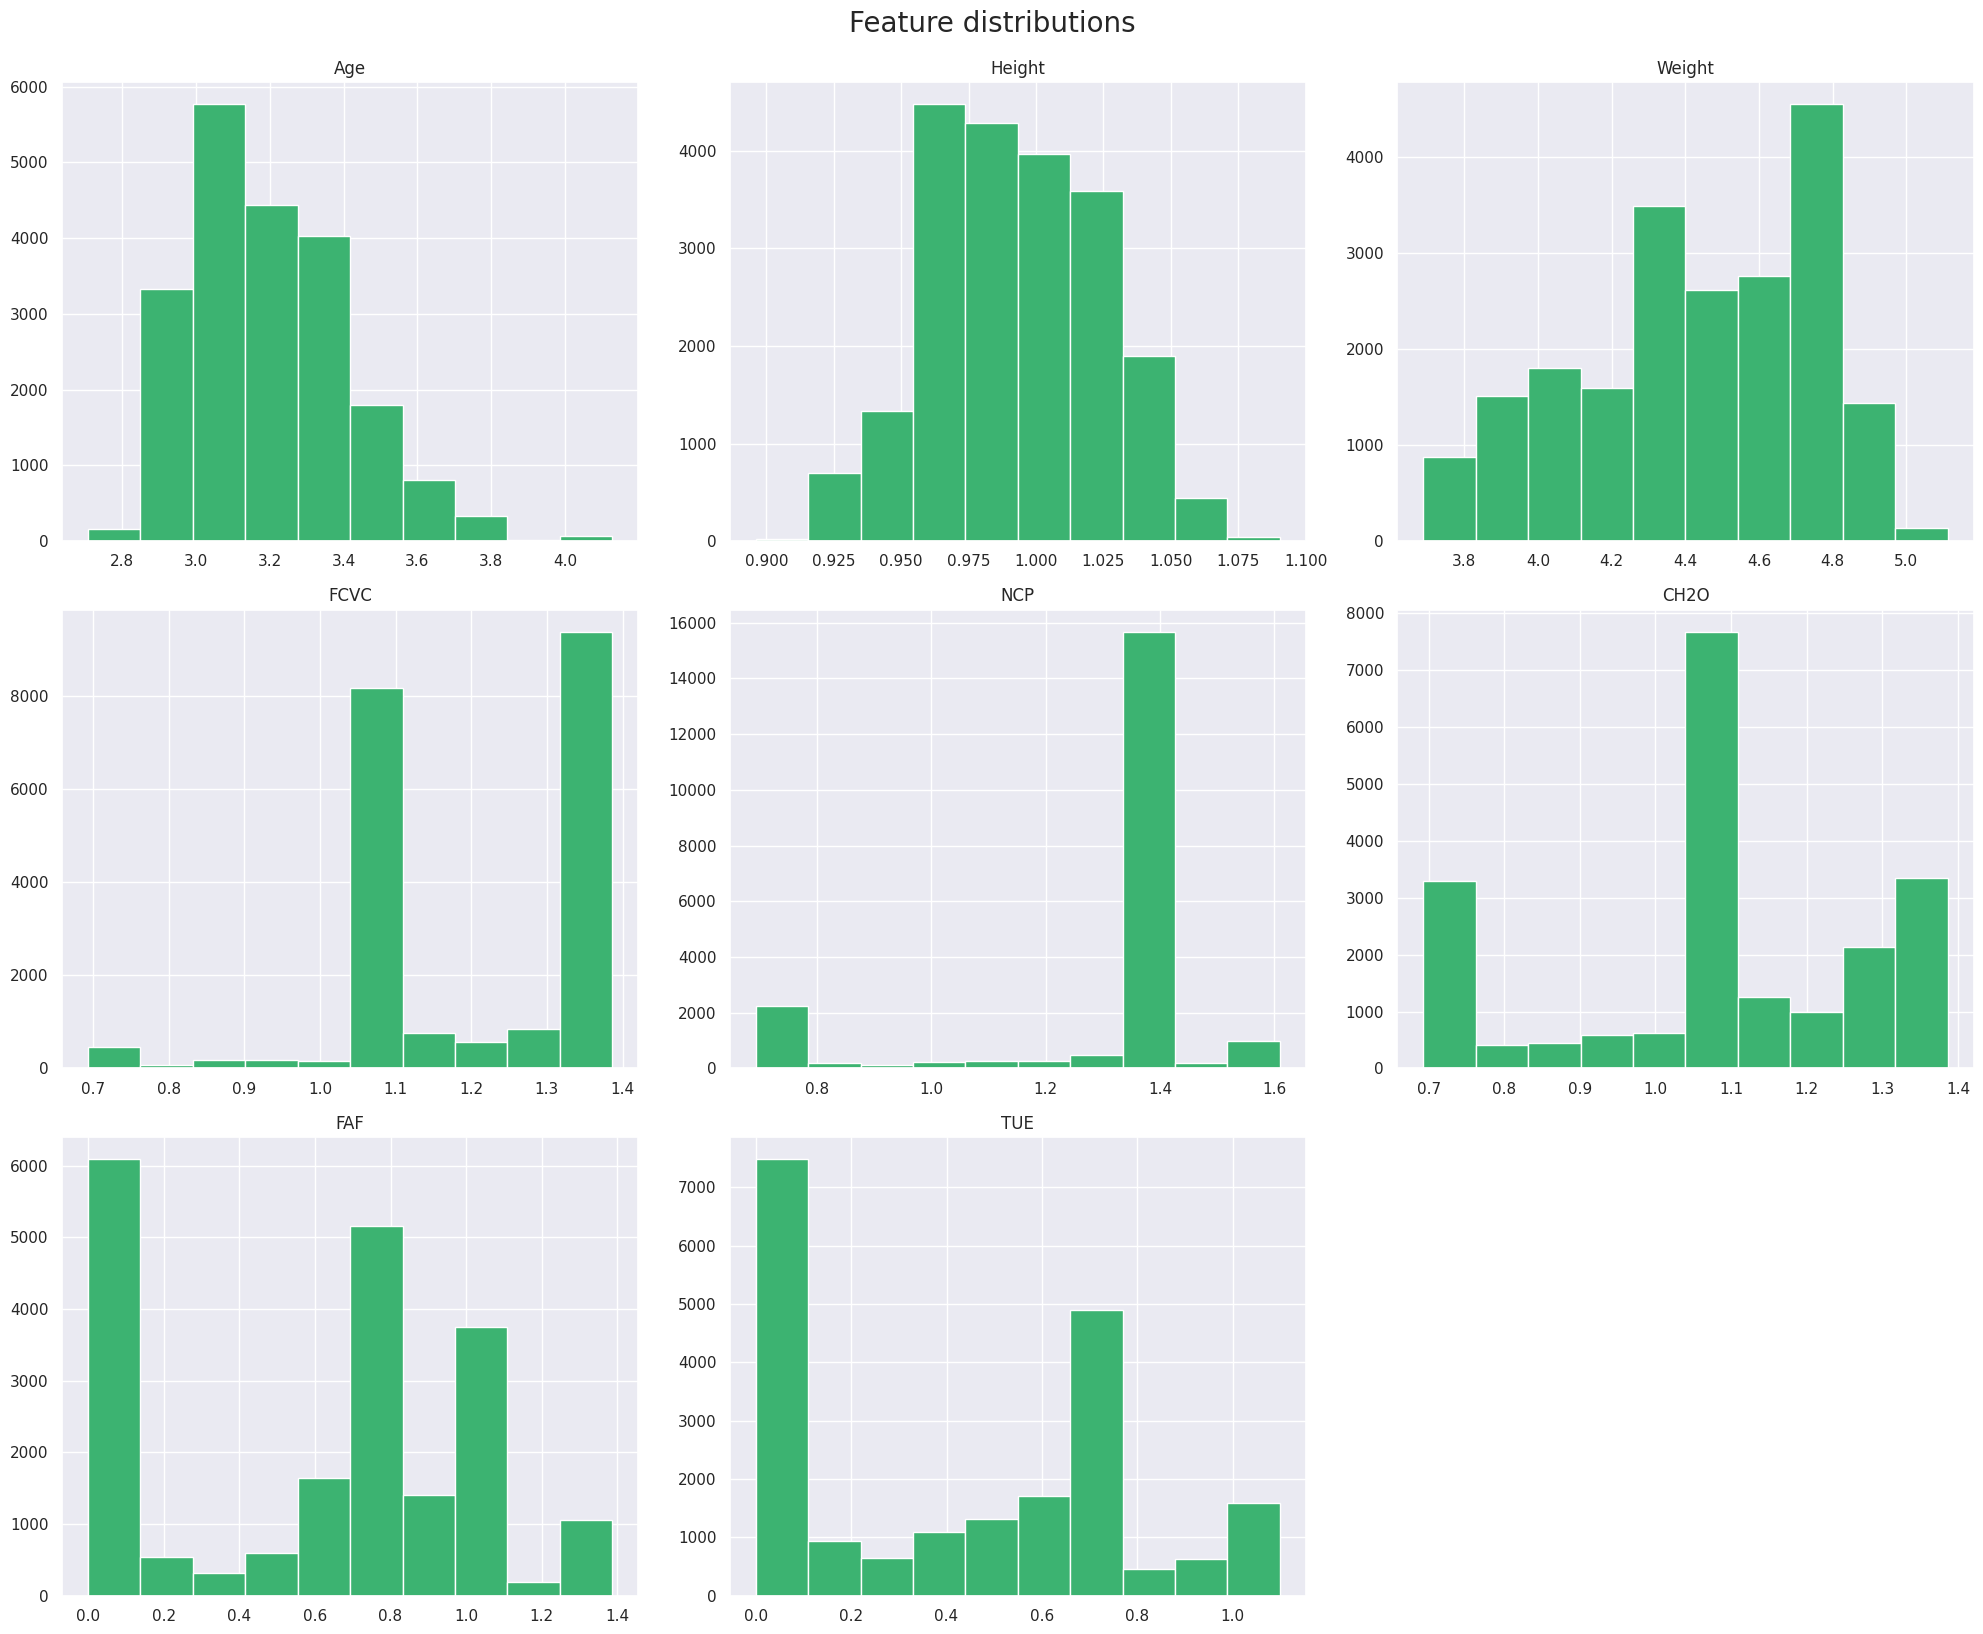

In [33]:
# 訓練データをX(説明変数)とy（目的変数）に分割する
X = train[numerical_features]
y = target

for column in X.columns.tolist():
    X[column] = X[column].apply(lambda x: np.log(x + 1))

X.hist(color='mediumseagreen')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

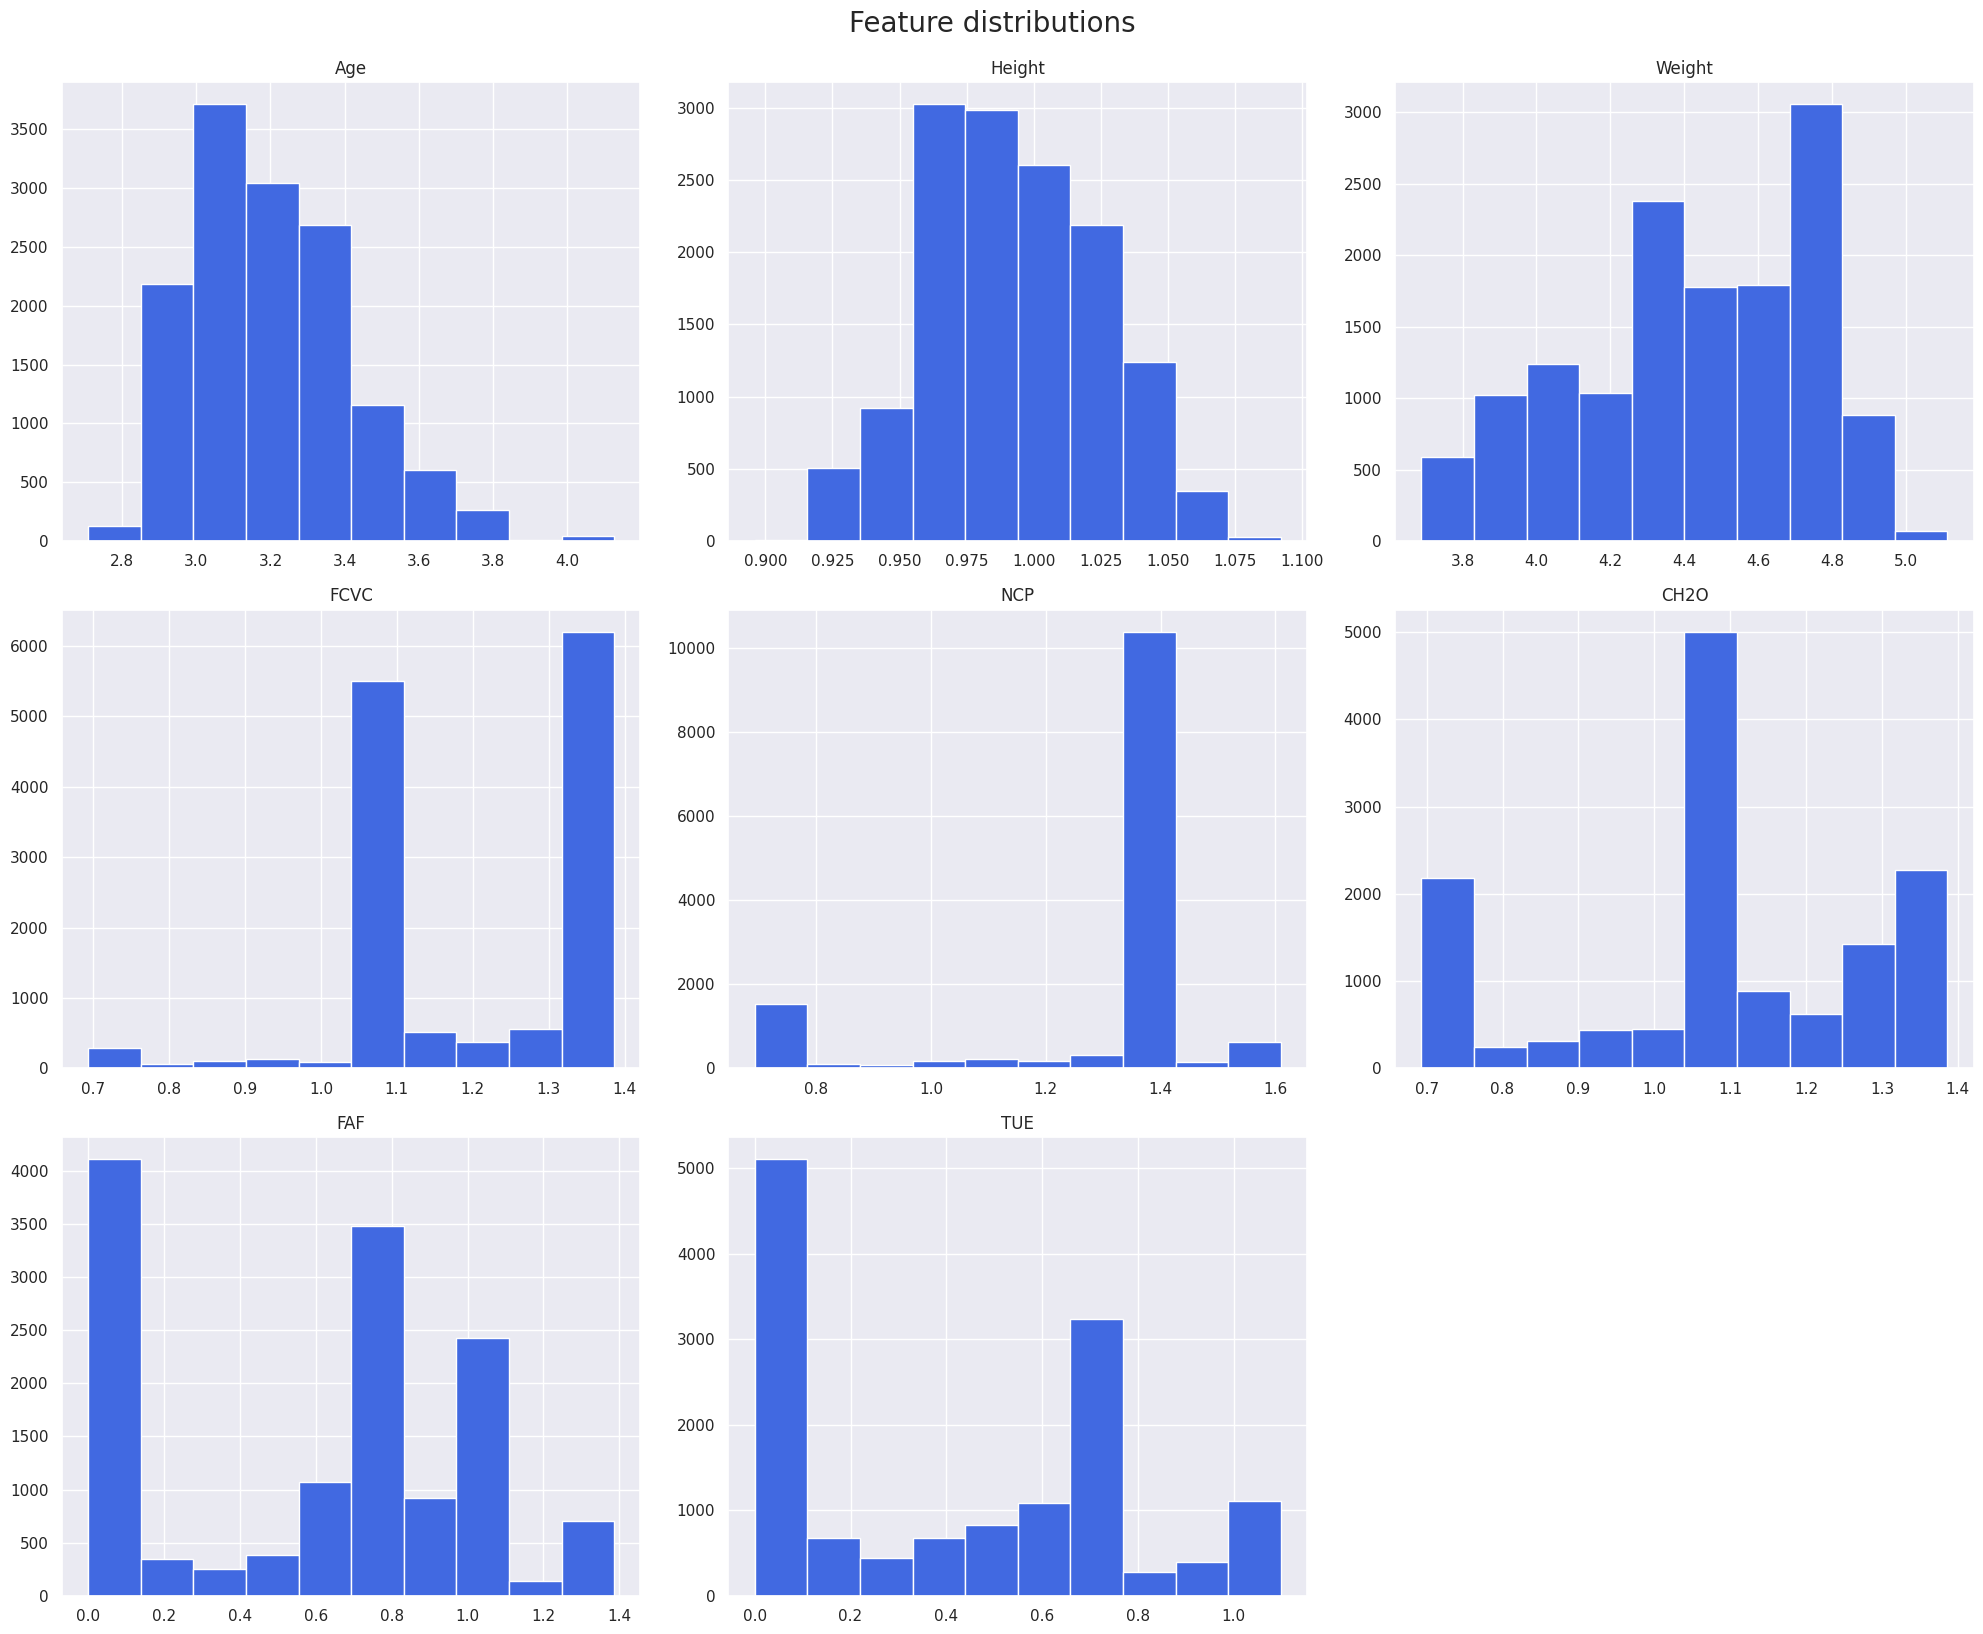

In [34]:
# テストデータも変換する
test_log = test[numerical_features]
for column in test_log.columns.tolist():
    test_log[column] = test_log[column].apply(lambda x: np.log(x + 1))

test_log.hist(color='royalblue')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

* 一部の説明変数において分布が確認しやすくなった

##### 数値型の説明変数の分布

カーネル密度推定（KDE: Kernel Density Estimation）
- 実データから、正規分布曲線のように下部の面積が1となるような連続した曲線（確率密度関数）を推定する

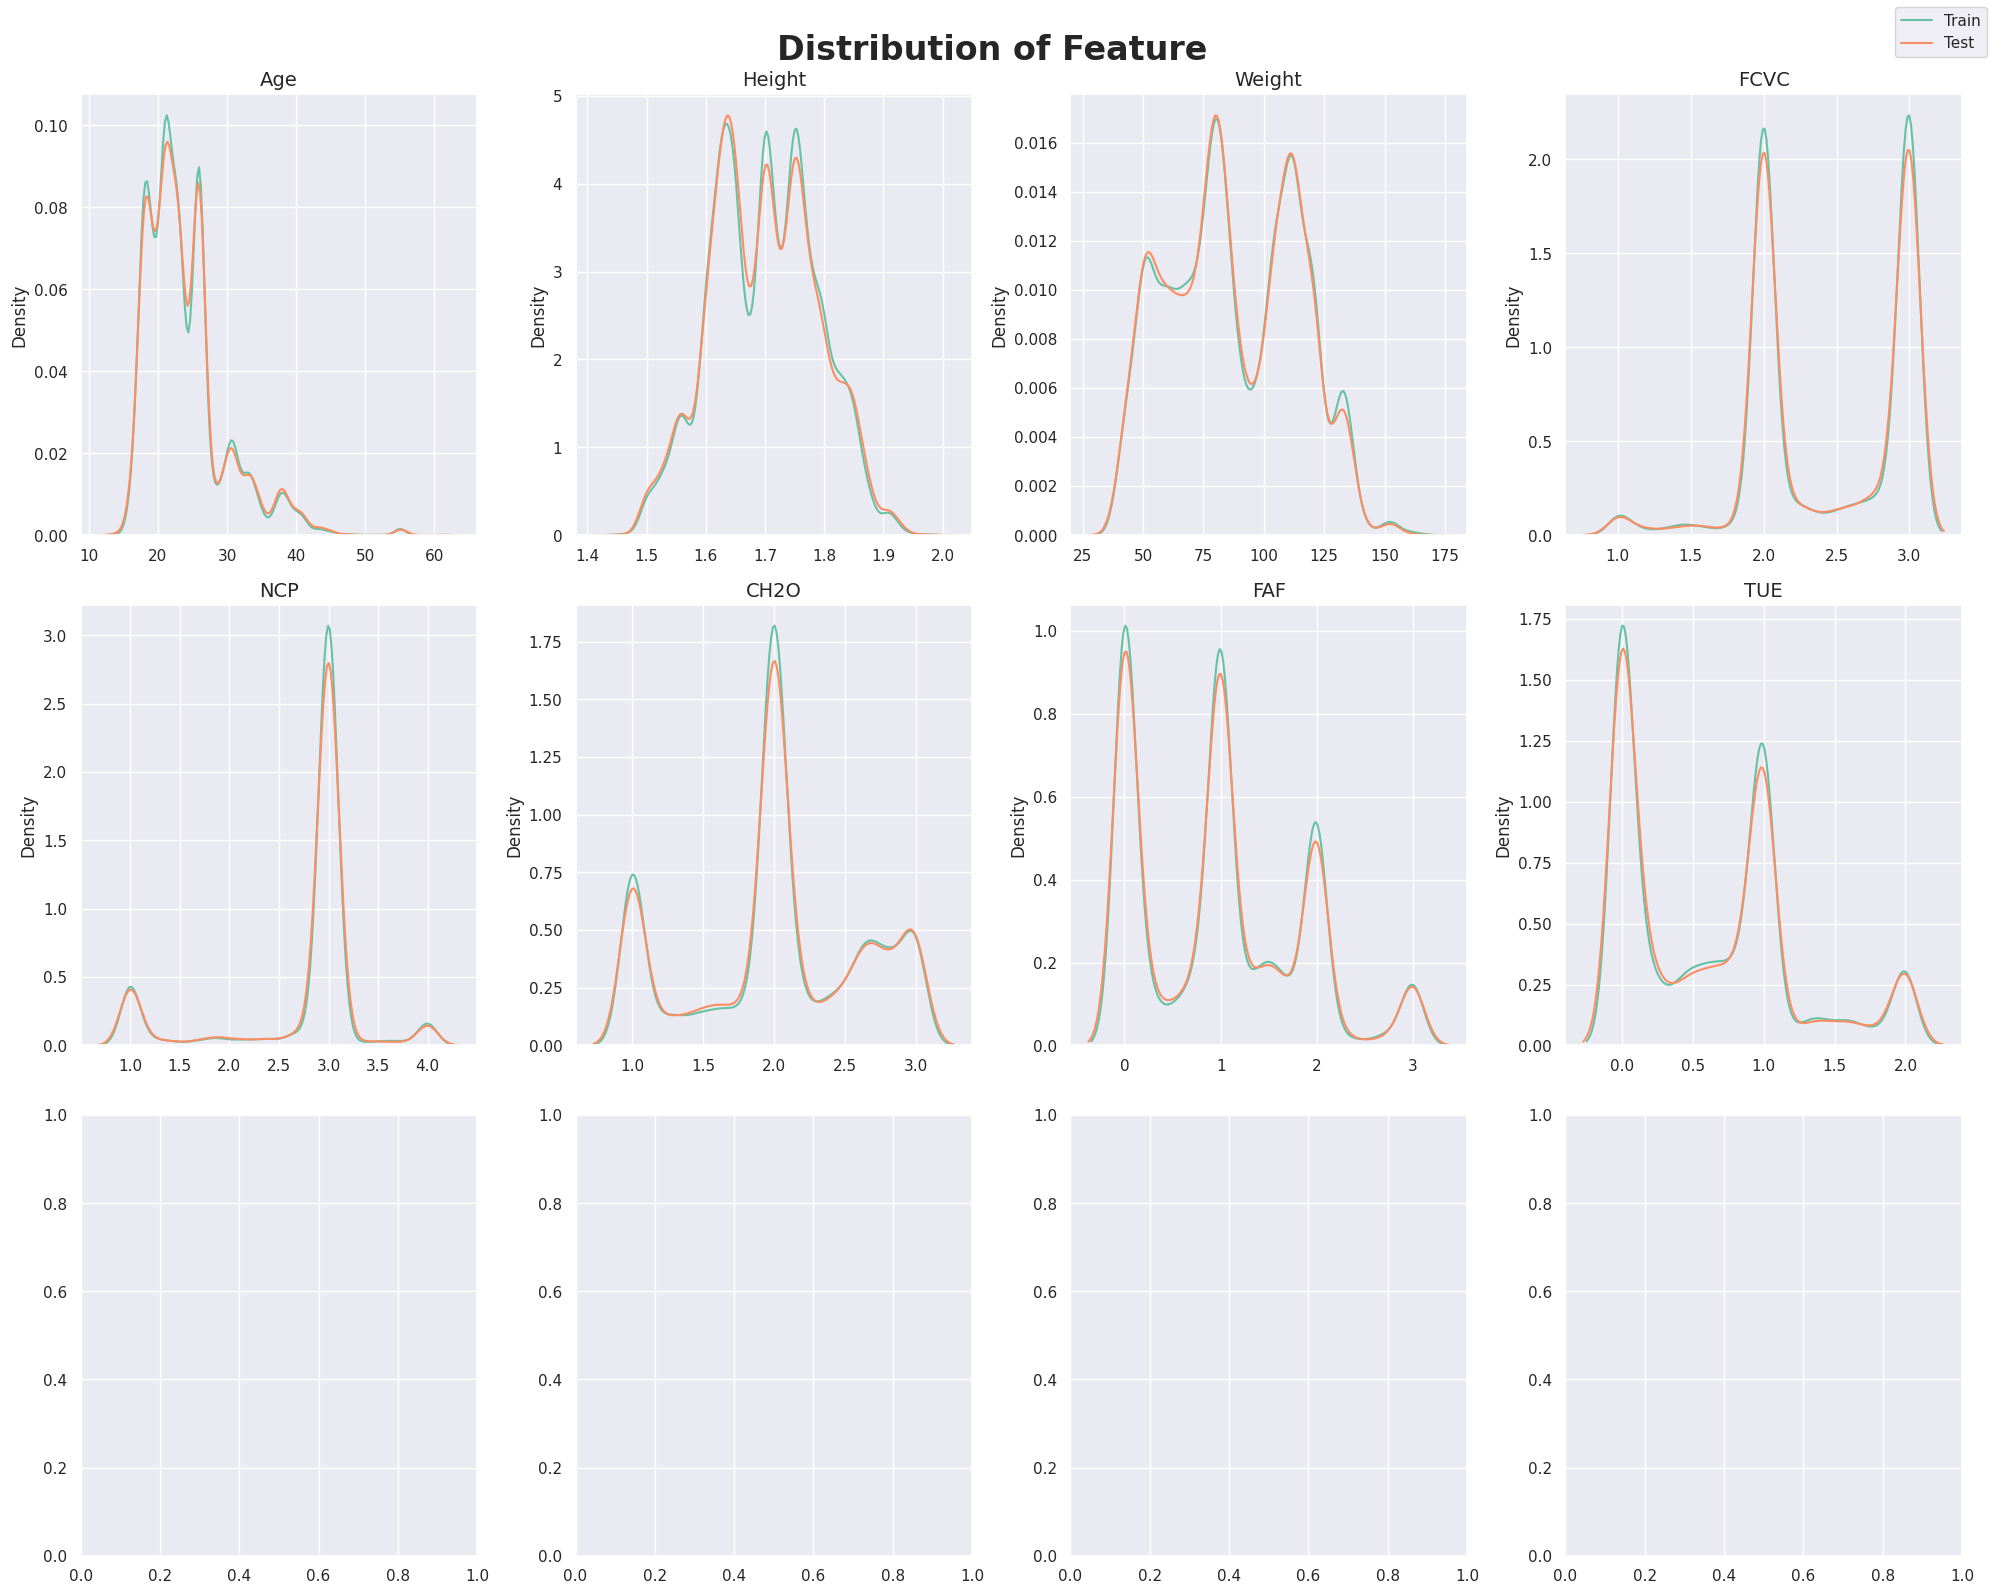

In [35]:
fig, ax = plt.subplots(len(numerical_features) // 4 + 1, 4)
ax = ax.flatten()
pal2 = sns.color_palette("Set2")
for i, column in enumerate(numerical_features):
    sns.kdeplot(train[column], ax=ax[i], color=pal2[0])
    sns.kdeplot(test[column], ax=ax[i], color=pal2[1], warn_singular=False)

    ax[i].set_title(f'{column}', size=14)
    ax[i].set_xlabel(None)

fig.suptitle('Distribution of Feature', fontsize=24, fontweight='bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

#### Adversarial Validation(敵対性の検証)

- Adversarial Validation(敵対性の検証)の目的
    - 訓練用のデータセットとテスト用データセットの間で値の分布に差があるかないかを検証すること
- もしもしこの検証の結果得られるROC-AUCスコアが0.5に近いようなら、二つのデータセットは同じ分布を持っていると考えていい
    - しかしその値が0.5から離れているようなら、分布が同様とは言えない

- 信頼できるCV（Cross-validation）スコアは同様の分布を持つデータセットからのみ取得されるため、あらかじめCVスコアが信頼できることを確認しておくためこの検証が必要

In [36]:
# 時間がかかるため、割愛
# def adversarial_validation(dataset_1=train, dataset_2 = test, label='Train-Test'):
#     adv_train = dataset_1.drop(target_col, axis=1)
#     adv_test = dataset_2.copy()

#     adv_train['is_test'] = 0
#     adv_test['is_test'] = 1

#     adv = pd.concat([adv_train, adv_test], ignore_index=True)
#     adv_shuffled = adv.sample(frac=1)
#     adv_X = adv_shuffled.drop('is_test', axis=1)
#     adv_y = adv_shuffled.is_test

#     skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
#     val_scores = []
#     predictions = np.zeros(len(adv))

#     for fold, (train_idx, val_idx) in enumerate(skf.split(adv_X, adv_y)):
#         adv_lr = make_pipeline(OneHotEncoder(cols=categorical_features), XGBClassifier(random_state=42))
#         adv_lr.fit(adv_X.iloc[train_idx], adv_y.iloc[train_idx])

#         val_preds = adv_lr.predict_proba(adv_X.iloc[val_idx])[:, 1]
#         predictions[val_idx] = val_preds
#         val_score = roc_auc_score(adv_y.iloc[val_idx], val_preds)
#         val_scores.append(val_score)

#     fpr, tpr, _ = roc_curve(adv['is_test'], predictions)

#     plt.figure(figsize=(10, 10), dpi=300)
#     sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
#     sns.lineplot(x=fpr, y=tpr, label="Adversarial Validation Classifier")
#     plt.title(f'{label} Validation = {np.mean(val_scores):.5f}', weight='bold', size=17)
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.show()

# adversarial_validation()

## 円グラフと棒グラフ

### 円グラフと棒グラフ（目的変数）

NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64


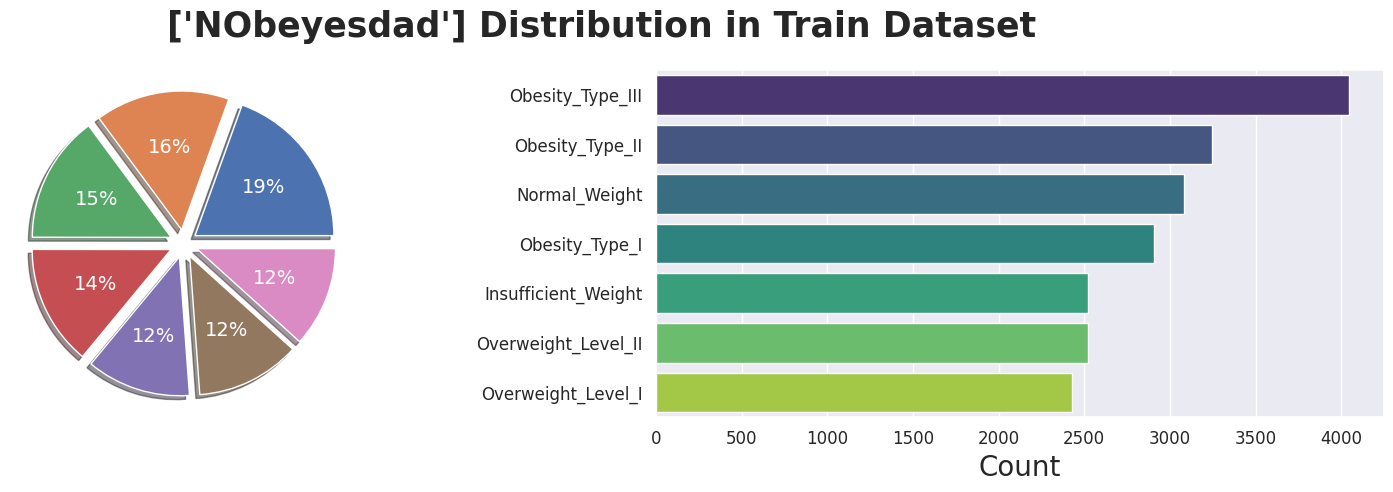

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax = ax.flatten()

ax[0].pie(
    target.value_counts(),
    shadow=True,
    explode=[.1 for i in range(target.nunique())],
    autopct='%1.f%%',
    textprops={'size': 14, 'color':'white'}
)

sns.countplot(data=train, y=target_col, ax=ax[1], palette='viridis', order=train[target_col].value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize=12)
ax[1].set_xlabel('Count', fontsize=20)
ax[1].set_ylabel(None)
plt.xticks(fontsize=12)

fig.suptitle(target_name + ' Distribution in Train Dataset', fontsize=25, fontweight='bold')
plt.tight_layout()

# 目的変数を数える
print(f'{train[target_col].value_counts()}') # 目的変数を指定する

カテゴリ型変数の分布

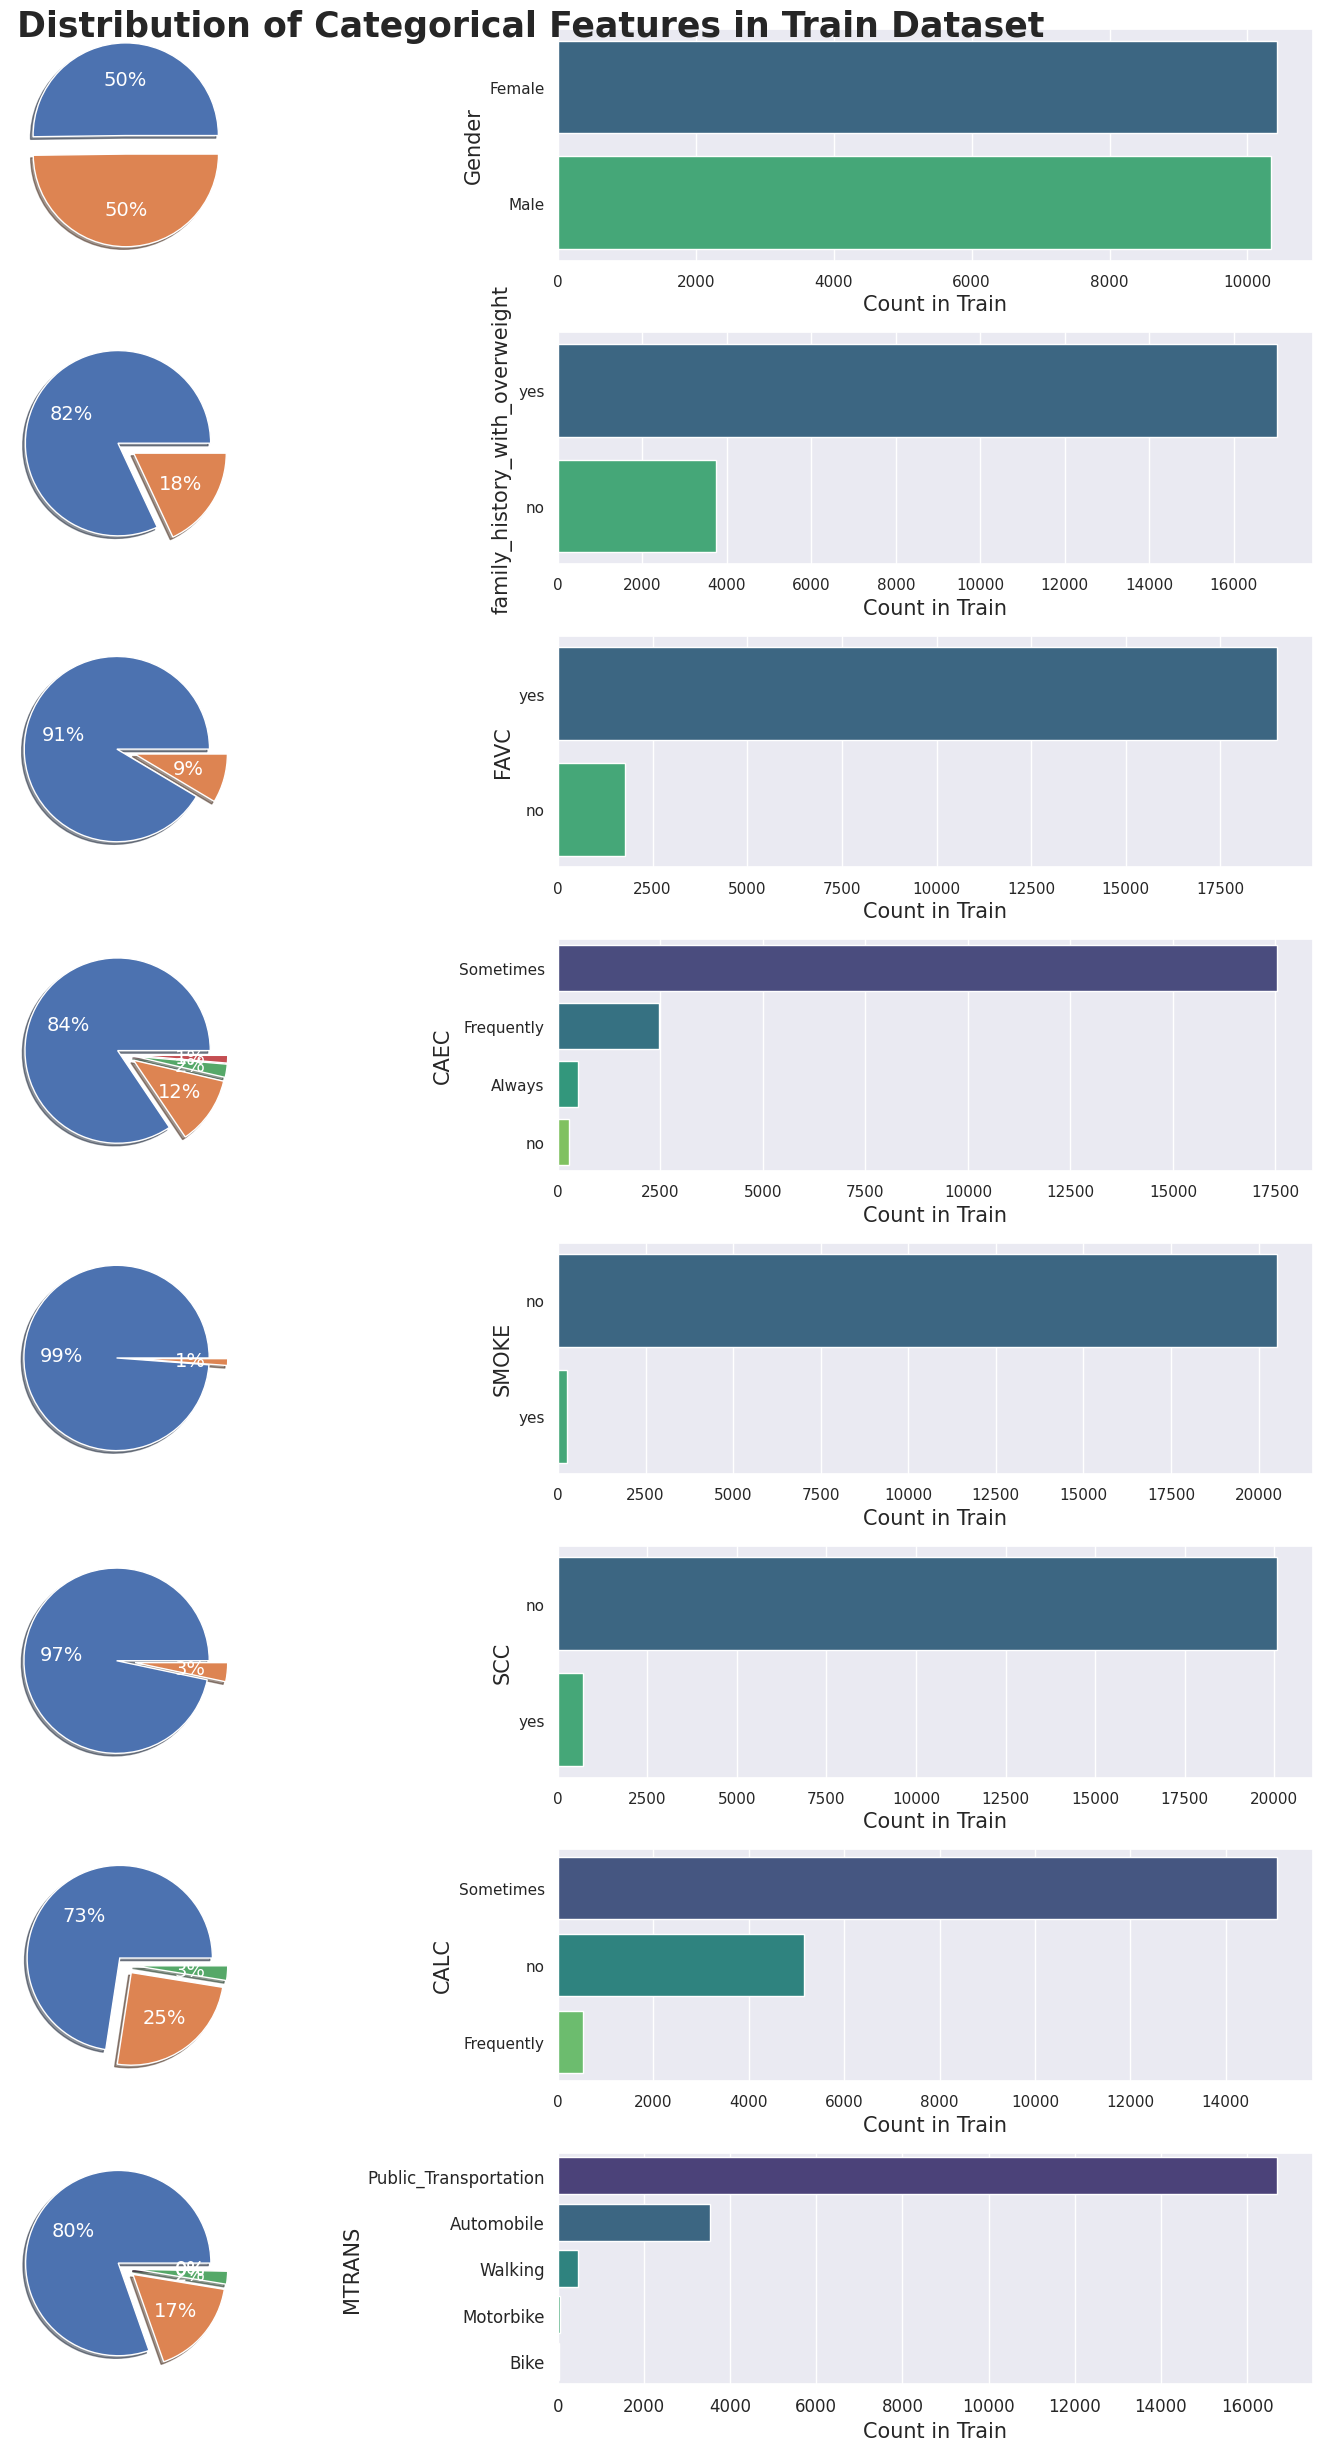

In [38]:
fig, ax = plt.subplots(len(categorical_features), 2, figsize=(16, 25))

for i, column in enumerate(categorical_features):
    ax[i][0].pie(
        train[column].value_counts(),
        shadow=True,
        explode=[.1 for i in range(train[column].nunique())],
        autopct='%1.f%%',
        textprops={'size': 14, 'color': 'white'}
    )

    sns.countplot(data=train, y=column, ax=ax[i][1], palette='viridis', order=train[column].value_counts().index)
    ax[i][1].yaxis.label.set_size(20)
    plt.yticks(fontsize=12)
    ax[i][1].set_xlabel('Count in Train', fontsize=15)
    ax[i][1].set_ylabel(f'{column}', fontsize=15)
    plt.xticks(fontsize=12)

fig.suptitle('Distribution of Categorical Features in Train Dataset', fontsize = 25, fontweight = 'bold')
plt.tight_layout()

### 箱ひげ図

数値型の説明変数

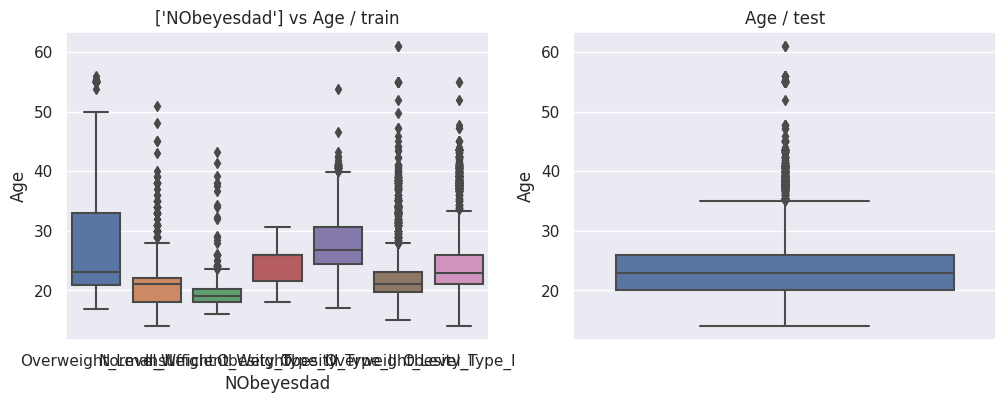

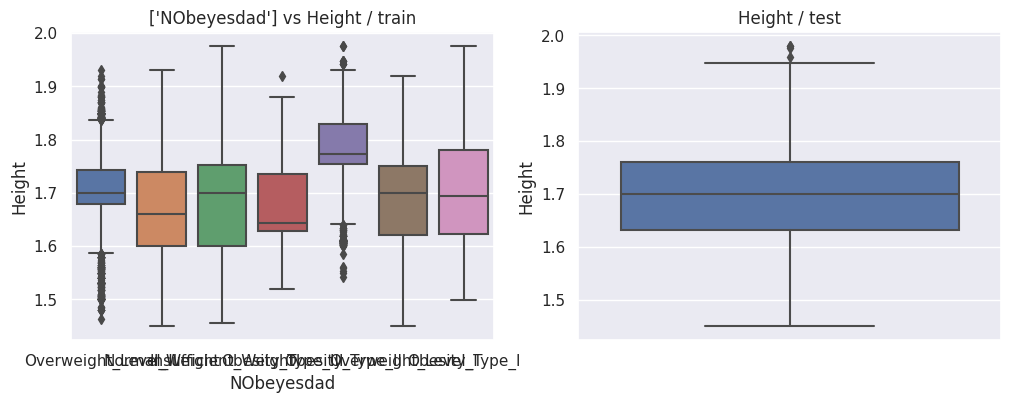

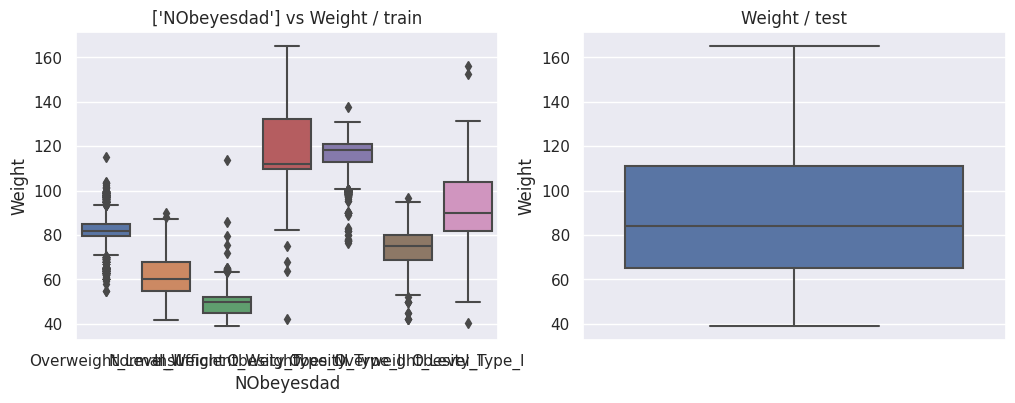

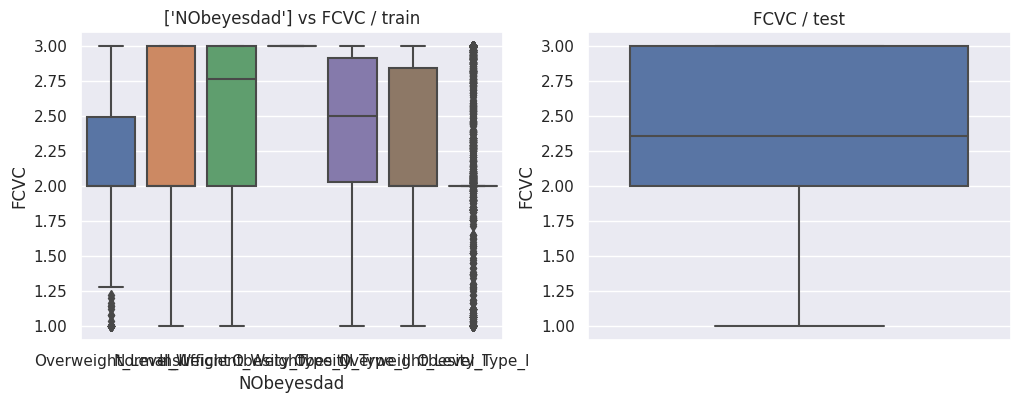

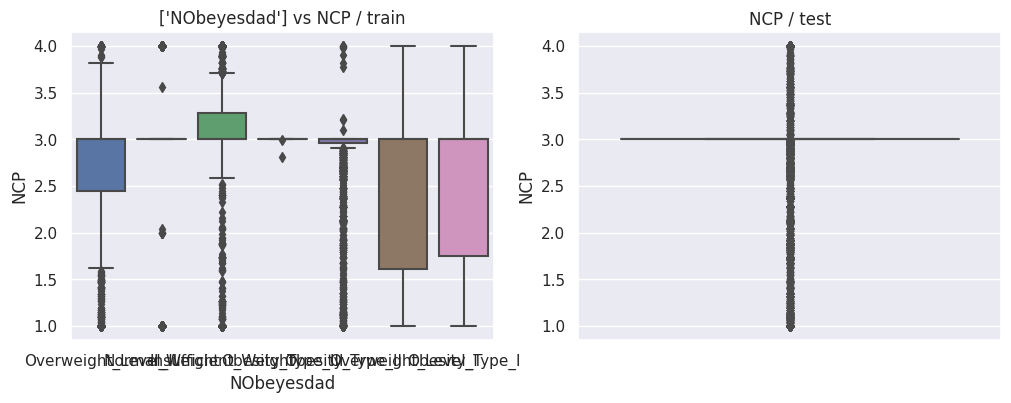

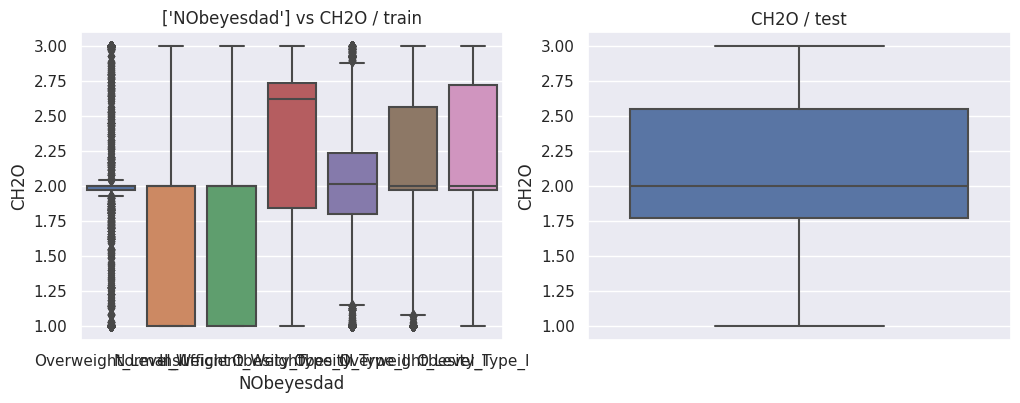

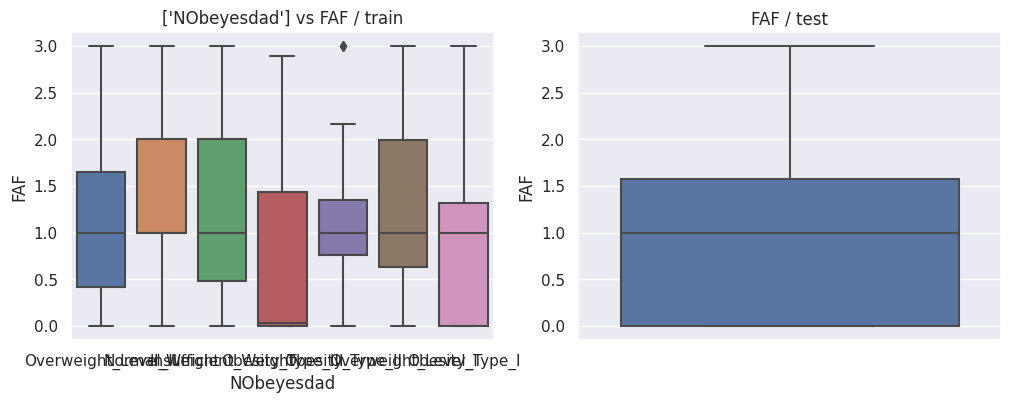

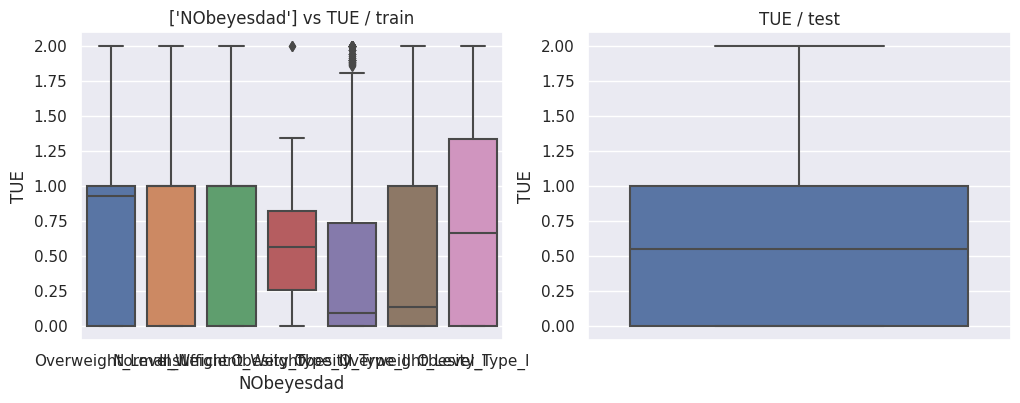

In [39]:
for feat in numerical_features:
    plt.figure(figsize=(12, 4))
    ax1 = plt.subplot(1, 2, 1)
    sns.boxplot(data=train, x=target, y=feat)
    plt.title(target_name + ' vs ' + feat + ' / train')
    x1 = plt.subplot(1, 2, 2)
    sns.boxplot(data=test, y=feat)
    plt.title(feat + ' / test')
    plt.show()

#### 箱ひげ図（目的変数）

In [40]:
# # データの範囲を調べる
# plt.figure(figsize=(10, 8))
# plt.boxplot(target, showmeans=True, meanline=True)
# plt.title('Data range of ' + target_name)
# plt.grid(True)

In [41]:
# # バイオリンプロット
# plt.figure(figsize=(10, 8))
# plt.violinplot(target, showmedians=True) # 中央値をマーキングする
# plt.title('Violin plot of ' + target_name)
# plt.grid(True)

### 特徴量の重要度評価

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2024
[LightGBM] [Info] Number of data points in the train set: 20758, number of used features: 8
[LightGBM] [Info] Start training from score -2.107483
[LightGBM] [Info] Start training from score -1.907353
[LightGBM] [Info] Start training from score -1.964779
[LightGBM] [Info] Start training from score -1.854892
[LightGBM] [Info] Start training from score -1.635203
[LightGBM] [Info] Start training from score -2.146276
[LightGBM] [Info] Start training from score -2.107879
CPU times: user 3.31 s, sys: 1.32 s, total: 4.63 s
Wall time: 3.98 s


<Axes: >

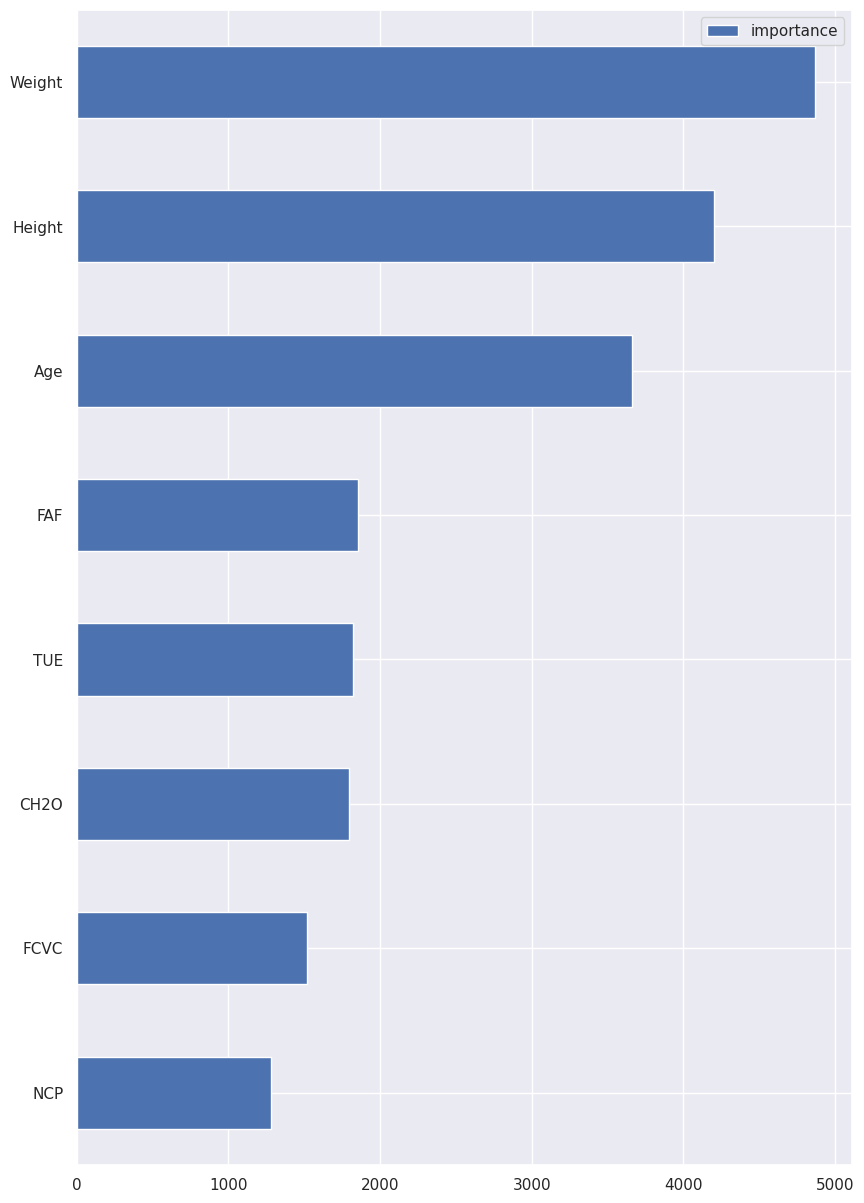

In [42]:
%%time

lgb = LGBMClassifier(
    random_state=42,
)

lgb.fit(X, y)
importance = lgb.feature_importances_

feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')

feature_importance.plot(kind='barh', figsize=(10, 15), color='b')

In [43]:
feature_importance

,importance
NCP,1284
FCVC,1518
CH2O,1794
TUE,1819
FAF,1858
Age,3661
Height,4201
Weight,4865


### 相関（ヒートマップ）

<Axes: >

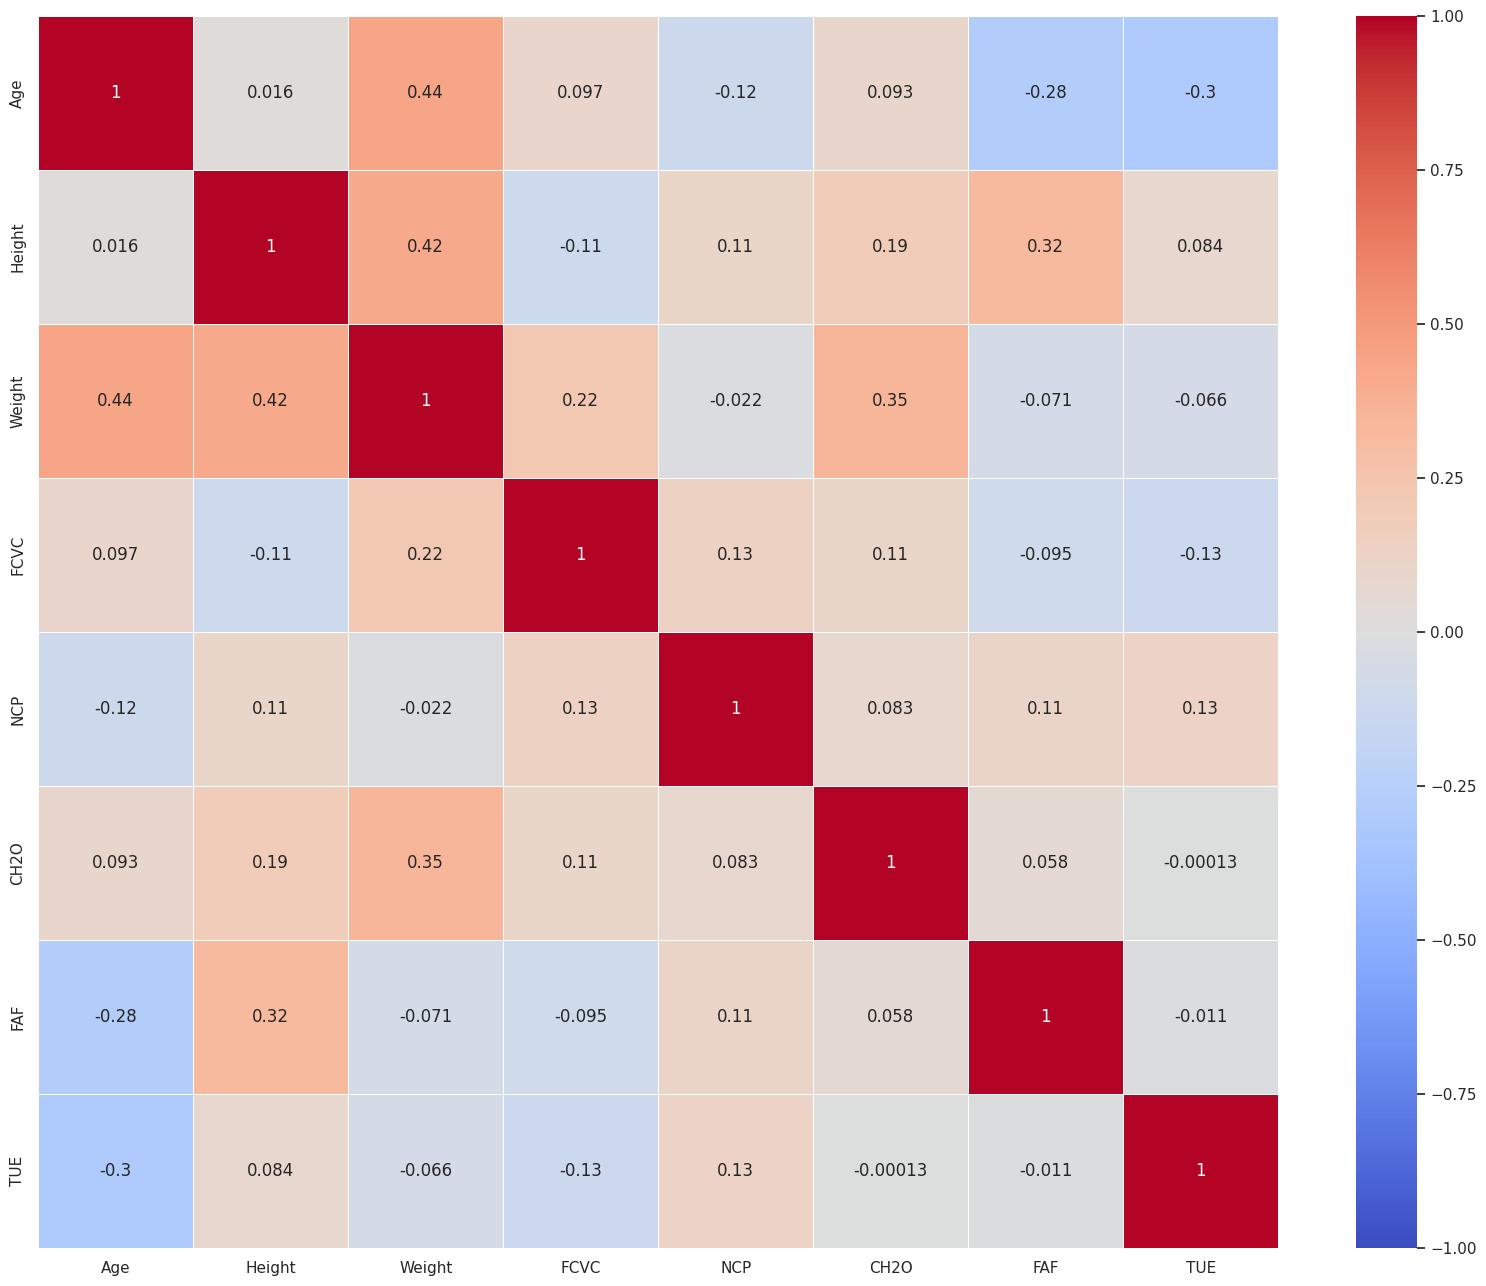

In [44]:
corr = train[numerical_features].corr(method='spearman')
plt.figure()
sns.heatmap(corr, linewidth=0.5, square=False, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

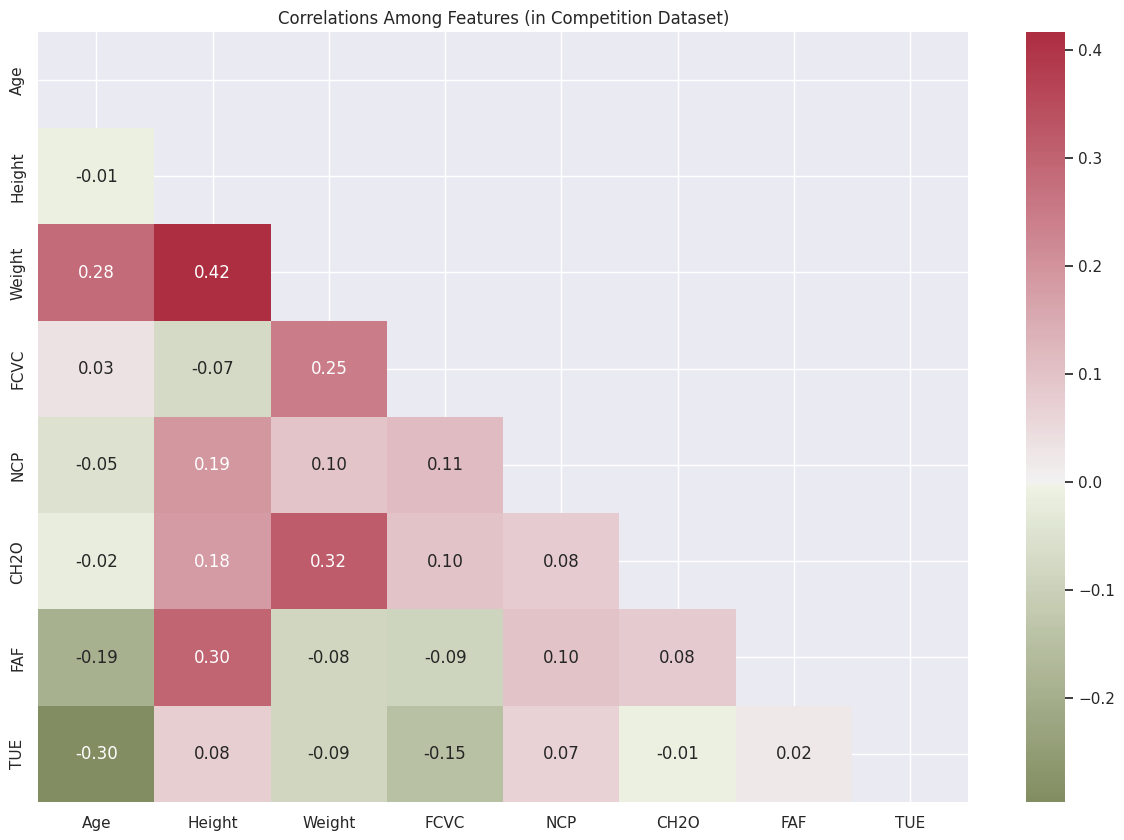

In [45]:
corr_mat_data = train[numerical_features].corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype=bool))

cmap = sns.diverging_palette(100, 7, s=75, l=40, n=5, center='light', as_cmap=True)

plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat_data, annot=True, cmap=cmap, fmt='.2f', center=0,
            annot_kws={'size': 12}, mask=data_mask).set_title('Correlations Among Features (in Competition Dataset)');

### 階層的クラスタリング

- 特徴間の関係の強さと方向性を調べる
- 特徴をクラスタリングする

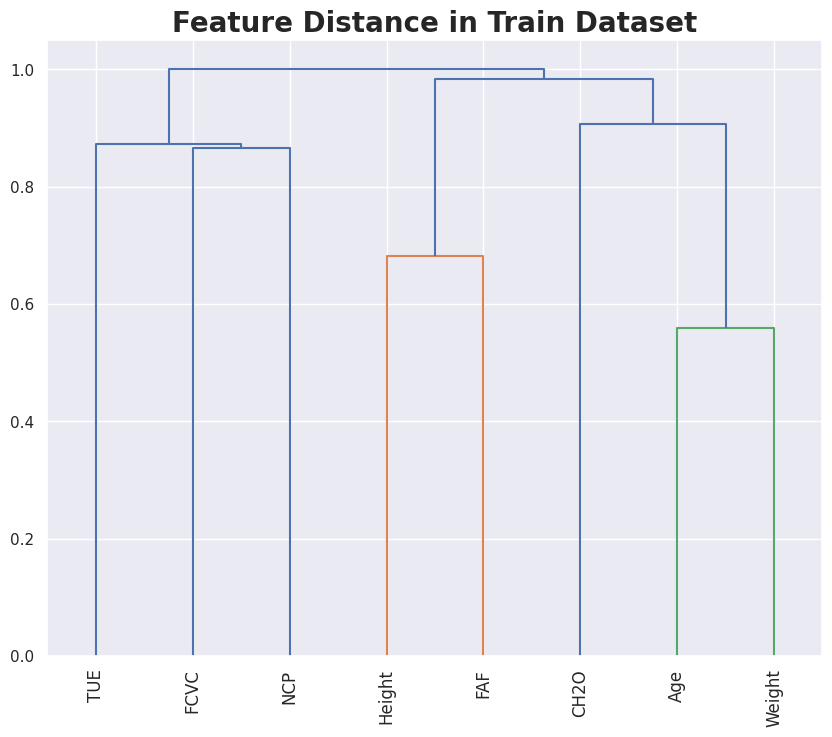

In [46]:
def distance(data, label = ''):
    corr = data.corr(method='spearman')
    dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')

    plt.figure(figsize=(10, 8))
    dendro = dendrogram(dist_linkage, labels=data.columns, leaf_rotation=90)
    plt.title(f'Feature Distance in {label} Dataset', weight='bold', size=20)
    plt.show()

distance(train[numerical_features], 'Train')

## EDAの可視化するためのライブラリ

In [47]:
# report = sv.compare([train, "Train"], [test, "Test"], target_feat=target_col)
# report.show_html(OUTPUT_DIR + "/EDA_sweetviz.html")

## 実行時間を調べるために使う

In [48]:
end_time = time.time()
lap = end_time - start_time
indi_time = changeHMS(lap)
indi_time

'42s'